## Compute BL effective heights

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn.linear_model import LinearRegression
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
    'sav_css':        False, # Save cases during fitting
    'sav_inf':        False, # Save cases inferences
}

PTHS = {
    'dsg_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/08_PAPER/'
}

### 1) FUNCTIONS

In [3]:
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def v_k10(v0, t, alpha=1., lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                             # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(alpha * t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + alpha * t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})                       # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * alpha * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})                       # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(alpha * t) + v0.rad * (np.exp(2 * alpha * t) - 1) / (2 * alpha)                                     # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * alpha * v0.rad) + np.log(v0.rad) / v0.rad + alpha * t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + alpha * t / v0.rad                                                                      # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((alpha - lbda) * t) + alpha * v0.rad * (1 - np.exp((2 * alpha - lbda) * t)) / (lbda - 2 * alpha)                                # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + alpha * (lbda * v0.rad ** 2 - 2 * alpha * v0.rad ** (lbda / alpha)) / (lbda * v0.rad * (lbda - 2 * alpha)) - alpha * np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + alpha * (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-alpha * t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        print('Error: R+ non defined.')
        R_plus = V_plus = np.nan
    
    return R_plus, V_plus

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def BL_height(r, a):
    '''a is the slope of the BL height'''
    return a * r

# def BL_height(r, a, Rp):
#     return a * (1 - np.exp(-(r / Rp) ** 0.1))

# def BL_height(r, a, Rp):
#     return (2 * a / np.pi) * np.arctan((r / Rp))

def u(r, alpha, fcor_ini, Rp_ini):
    u    = np.zeros_like(r) 
    u_in = -alpha * fcor_ini * r
    u_ou = -alpha * fcor_ini * (Rp_ini ** 2) / r
    u[r <= Rp_ini] = u_in[r <= Rp_ini]
    u[r >= Rp_ini] = u_ou[r >= Rp_ini]
    return u # dimensional

def propagate(r, a, alpha, V_ini, fcor_ini, dt=1, fitting_mode=False, Cd_plus=2.5e-3):
    # Compute R+, V+
    R_plus, V_plus = compute_RV_plus(r, V_ini, fcor_ini, PRMS['n'])
    # print('R+ = {:.0f}, V+ = {:.1f}'.format(R_plus, V_plus))
    
    # Compute BL height 
    h              = BL_height(r, a / 1000)
    # h                = a * np.ones_like(r)
    # h              = BL_height(r, a, R_plus)
    
    # Compute lambda
    # M_abs          = r * V_ini + 0.5 * fcor_ini * (r ** 2)
    M_rel          = r * V_ini
    lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) # dimensional
    # lbda           = float(Cd_plus * R_plus * (V_plus ** 2)) / (h * M_rel) - (fcor_ini * r * u(r, alpha, fcor_ini, R_plus) / M_rel) # dimensional
    lbda           = lbda / fcor_ini                                       # non-dimensional
    
    # plt.plot(r / 1000, 1e6 / r ** 2, c='k')
    # plt.plot(r / 1000, lbda);plt.yscale('log');plt.xlim(0, 300);plt.show()
    
    # Normalize
    V_nrm = xr.DataArray(
        data=V_ini / (fcor_ini * R_plus),
        coords={'rad': r / R_plus}
    )
    
    # Apply KK10
    V = v_k10(V_nrm, dt, alpha, lbda=lbda) * fcor_ini * R_plus             # dimensional
    
    # # Option 1: Fit the whole curve
    # # In fitting mode, match values of nan with values of initial profile so that it doesn't count
    # if fitting_mode:
    #     V[np.isnan(V)] = V_ini[np.isnan(V)]
    
    # Option 2: Fit Vmax
    if fitting_mode:
        V = np.nanmax(V)

    return V

In [49]:
# ### CREATE DATASET FOR DAN

# dsg       = xr.open_dataset(PTHS['dsg_pth'])
# dsg.attrs = {}

# dsg.storm_name.attrs['description'] = 'Storm name'
# dsg.storm_id.attrs['description']   = 'Storm ATCF ID'
# dsg.Rmax_1D.attrs['long_name']      = 'Radius of maximum winds from the azimuthally-averaged wind profile'
# dsg.Rmax_1D.attrs['units']          = 'km'
# dsg.Rmax_1D.attrs['description']    = 'Radius of maximum winds computed as the location of the maximum of the azimuthally-averaged wind profile'
# dsg.Vmax_1D.attrs['long_name']      = 'Maximum wind speed from the azimuthally-averaged wind profile'
# dsg.Vmax_1D.attrs['units']          = 'm/s'
# dsg.Vmax_1D.attrs['description']    = 'Maximum wind speed computed as the maximum of the azimuthally-averaged wind profile'
# dsg.R17_1D.attrs['long_name']       = 'Radius of gale-force winds (R34) from the azimuthally-averaged wind profile'
# dsg.R17_1D.attrs['units']           = 'km'
# dsg.R17_1D.attrs['description']     = 'Radius of gale-force winds computed as the outer-radius where the azimuthally-averaged wind profile equals 34 knots'
# dsg.R26_1D.attrs['long_name']       = 'Radius of damaging-force winds (R50) from the azimuthally-averaged wind profile'
# dsg.R26_1D.attrs['units']           = 'km'
# dsg.R26_1D.attrs['description']     = 'Radius of damaging-force winds computed as the outer-radius where the azimuthally-averaged wind profile equals 50 knots'
# dsg.R33_1D.attrs['long_name']       = 'Radius of hurricane-force winds (R64) from the azimuthally-averaged wind profile'
# dsg.R33_1D.attrs['units']           = 'km'
# dsg.R33_1D.attrs['description']     = 'Radius of hurricane-force winds computed as the outer-radius where the azimuthally-averaged wind profile equals 64 knots'

# vrs = [
#     'wind_speed', 'track_vmax', 'distance_to_coast', 'cyclone_speed', 'cyclone_speed_std', 'rotation_angle', 'rotation_angle_std', 'vmax', 'rmax', 
#     'tco_radii_ms_all', 'tco_radii_ms_FR', 'tco_radii_ms_FL', 'tco_radii_ms_RR', 'tco_radii_ms_RL', 'storm_name', 'storm_id', 
#     'Rmax_1D', 'Vmax_1D', 'R17_1D', 'R26_1D', 'R33_1D', 'lon_center', 'lat_center'
# ]

# dsg[vrs].to_netcdf('/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/ds_dan.nc')

### 2) SAR DATA

In [4]:
dsg  = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 25, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

# Manually add Goni because its R17 is nan (I don't know why)
goni      = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/Goni_sample.nc')
dsg       = xr.concat((dsg, goni), dim='time')

# Select IDs where there are at least 2 SAR images
ids, cts  = np.unique(dsg.storm_id, return_counts=True)
valid_ids = ids[cts > 1]
valid_cts = cts[cts > 1]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Nb of storms: 161
SAR Mean Rmax = 31 km
SAR Mean R64  = 57 km


### 3) REGRESSION

In [19]:
# COLORMAP
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)
l      = 5 # nb of model steps to display
clrs   = cm(np.linspace(0, 1, l + 1))

# Parameters
time_thresh  = 20

# Initialization
IDXS_INI     = []
IDXS_FIN     = []
TC_IDS       = []
DELTA_HS     = []
VMXS_INI     = []
RMXS_INI     = []
FCRS_INI     = []
FCRS_FIN     = []
VMXS_FIN     = []
RMXS_FIN     = []
AS           = []
RPLS_INI     = []
RPLS_FIN     = []
RPLS_MOD     = []
VPLS_INI     = []
VPLS_FIN     = []
HPLS         = []
HPLS_FIN     = []
DMPLS        = []
DMPLS_FIN    = []
BHOLS        = []
# Errors
RMSES        = []
RMSES_PRS    = []
REL_ERRS     = []
REL_ERRS_PRS = []
r_ref        = np.linspace(0, 10, 1001)

# Iterate
for tc_id in tqdm(valid_ids):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time) - 1):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            # print(idx_ini, idx_fin)
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)   
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if (delta_h <= time_thresh) & (delta_h > 1):
                V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
                Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
                Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
                fcor_ini   = float(abs(coriolis(ds_ini.lat_center)))
                fcor_fin   = float(abs(coriolis(ds_fin.lat_center)))
                
                # dt
                tau      = ((1 / fcor_ini) / 3600)
                dt       = delta_h / tau
                
                # Alpha, h is constant
                # alpha = 0.3
                alpha = 0.5
                # alpha = 1
                
                # Fitting
                a_fit, pcov = curve_fit(
                    lambda r, a: propagate(r, a, alpha, Vh_ini, fcor_ini, dt, fitting_mode=True),
                    rs,
                    # Vh_fin,          # Option 1: Fit the whole curve
                    np.nanmax(V_fin),  # Option 2: Fit Vmax
                    p0=1000,
                    bounds=[10, 10000],
                    # p0=100,
                    # bounds=[10, 1000],
                )
                
                # Model
                V = propagate(rs, a_fit, alpha, Vh_ini, fcor_ini, dt=dt)
            
                print(tc_id)
                print('delta_h = {:.1f}hr'.format(delta_h))
                print('a = {:.2f}'.format(float(a_fit)))
                
                # Compute R+ metrics
                Rp_ini, Vp_ini   = compute_RV_plus(rs, Vh_ini,    float(abs(coriolis(ds_ini.lat_center))), PRMS['n'])
                Rp_fin, Vp_fin   = compute_RV_plus(rs, Vh_fin,    float(abs(coriolis(ds_fin.lat_center))), PRMS['n'])
                V                = propagate(rs, a_fit, alpha, Vh_ini, fcor_ini, dt)
                Rp_mod, Vp_mod   = compute_RV_plus(rs, V,         float(abs(coriolis(ds_fin.lat_center))), PRMS['n'])
                # Hp               = np.nan
                Hp               = BL_height(Rp_ini, a_fit / 1000)
                # Hp               = BL_height(Rp_ini, a_fit, Rp_ini)
                dMp              = np.gradient(rs * Vh_ini + 0.5 * fcor_ini * (rs ** 2), dr)[rs >= Rp_ini][0] # dM/dr at R+
                dMp_fin          = np.gradient(rs * Vh_fin + 0.5 * float(abs(coriolis(ds_fin.lat_center))) * (rs ** 2), dr)[rs >= Rp_fin][0] # dM/dr at R+
                
                # Compute RMSE
                rmse        = np.sqrt(np.nanmean((V - Vh_fin) ** 2))      # Model
                rmse_prs    = np.sqrt(np.nanmean((Vh_ini - Vh_fin) ** 2)) # Persistence    
                # Option 1: Compute relative to Holland final profile
                rel_err          = (V - Vh_fin) / Vh_fin
                rmx              = rs[np.nanargmax(Vh_fin)]
                r_star           = rs / rmx
                rel_err_star     = np.interp(r_ref, r_star, rel_err)
                rel_err_prs      = (Vh_ini - Vh_fin) / Vh_fin             # Persistence
                rel_err_prs_star = np.interp(r_ref, r_star, rel_err_prs)  # Persistence
                    
                # Appends
                IDXS_INI.append(idx_ini), IDXS_FIN.append(idx_fin), TC_IDS.append(tc_id), DELTA_HS.append(delta_h), AS.append(float(a_fit))  
                VMXS_INI.append(np.nanmax(V_ini)), RMXS_INI.append(rs[np.nanargmax(V_ini)]), FCRS_INI.append(fcor_ini),
                VMXS_FIN.append(np.nanmax(V_fin)), RMXS_FIN.append(rs[np.nanargmax(V_fin)]), FCRS_FIN.append(fcor_fin),
                RPLS_INI.append(Rp_ini), RPLS_FIN.append(Rp_fin), RPLS_MOD.append(Rp_mod), VPLS_INI.append(Vp_ini), VPLS_FIN.append(Vp_fin),
                HPLS.append(float(Hp)), DMPLS.append(float(dMp)), DMPLS_FIN.append(float(dMp_fin)), BHOLS.append(float(ds_ini.B_hol))
                RMSES_PRS.append(rmse_prs), RMSES.append(rmse)
                REL_ERRS.append(rel_err_star), REL_ERRS_PRS.append(rel_err_prs_star)

                # Plot
                if PRMS['sav_css']:
                    plt.title('{}, idx_ini = {}, idx_fin = {} \n delta_h = {:.1f} hrs, a = {:.2f}'.format(tc_id, idx_ini, idx_fin, delta_h, float(a_fit)), weight='bold')
                    # plt.suptitle('Note that alpha = 0.3')
                    # SAR                  
                    plt.plot(rs / 1000, V_ini, c='k',         linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(ds_ini.time, unit='m')[5:]))
                    plt.plot(rs / 1000, V_fin, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(ds_fin.time, unit='m')[5:]))
                    # # Holland
                    plt.plot(rs / 1000, Vh_ini, c='k', label='Holland initial')
                    # plt.plot(rs / 1000, Vh_fin, linewidth=3, linestyle='dotted', c='orangered', label='Holland final')
                    # # Model
                    # for k in range(1, l + 1):
                    #     V = propagate(rs, a_fit, Vh_ini, fcor_ini, dt=k * dt / l)
                    #     plt.plot(rs / 1000, V, linestyle='dashed', c=clrs[k], label='MODEL, step {}'.format(k))
                    plt.plot(rs / 1000, V, linestyle='dashed', c='orangered', label='MODEL')
                    # V = propagate(rs, a_fit, Vh_ini, fcor_ini, dt=dt)
                    # plt.plot(rs / 1000, V, c='orangered', linestyle='dashed', label='MODEL')
                    # V2 = propagate(rs, a_fit, Vh_ini, fcor_ini, dt=dt/2)
                    # plt.plot(rs / 1000, V2, c='orange', linestyle='dashed', label='MODEL mid-time')
                    # Grids
                    plt.grid();plt.legend(loc='upper right')
                    plt.xlim(0, 300)
                    plt.xlabel('r (km)')
                    plt.ylabel('Wind speed (m/s)')

                    # Save
                    plt.savefig(PTHS['sav_dir'] + 'cases/{}_ini{}_fin{}'.format(tc_id, idx_ini, idx_fin));plt.clf()
                                   
dsf = xr.Dataset(
    data_vars={
        'tc_id':       ('pair', np.array(TC_IDS).astype(str)),
        'idx_ini':     ('pair', IDXS_INI),
        'idx_fin':     ('pair', IDXS_FIN),
        'delta_h':     ('pair', DELTA_HS),
        'a':           ('pair', AS),
        'fcor_ini':    ('pair', FCRS_INI),
        'fcor_fin':    ('pair', FCRS_FIN),
        'vmx_ini':     ('pair', VMXS_INI),
        'vmx_fin':     ('pair', VMXS_FIN),
        'rmx_ini':     ('pair', RMXS_INI),
        'rmx_fin':     ('pair', RMXS_FIN),
        'Rp_ini':      ('pair', RPLS_INI),
        'Rp_fin':      ('pair', RPLS_FIN),
        'Rp_mod':      ('pair', RPLS_MOD),
        'Vp_ini':      ('pair', VPLS_INI),
        'Vp_fin':      ('pair', VPLS_FIN),
        'Hp':          ('pair', HPLS),
        'dMp':         ('pair', DMPLS),
        'dMp_fin':     ('pair', DMPLS_FIN),
        'B_hol':       ('pair', BHOLS),
        'rmse':        ('pair', RMSES),
        'rmse_prs':    ('pair', RMSES_PRS),
        'rel_err':     (('pair', 'r*'), REL_ERRS),
        'rel_err_prs': (('pair', 'r*'), REL_ERRS_PRS),
    }
)

  0%|          | 0/39 [00:00<?, ?it/s]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


al122021
delta_h = 11.8hr
a = 348.99


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


al122021
delta_h = 12.3hr
a = 138.43


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


al182021
delta_h = 11.9hr
a = 1158.89


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep102018
delta_h = 12.5hr
a = 705.38


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep102018
delta_h = 12.5hr
a = 729.33


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep102018
delta_h = 12.5hr
a = 443.06


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep132016
delta_h = 12.5hr
a = 663.32


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep142018
delta_h = 12.4hr
a = 762.83


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep162018
delta_h = 12.2hr
a = 1153.65


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep182020
delta_h = 12.7hr
a = 389.51


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep182020
delta_h = 11.9hr
a = 315.33


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep212018
delta_h = 12.5hr
a = 202.61


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


ep212018
delta_h = 12.5hr
a = 231.79


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


sh072018
delta_h = 13.0hr
a = 297.15


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


sh172019
delta_h = 10.9hr
a = 90.75


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


sh192021
delta_h = 11.1hr
a = 720.49


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


sh222019
delta_h = 10.9hr
a = 100.05


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


sh222019
delta_h = 12.9hr
a = 87.13


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


sh242021
delta_h = 10.9hr
a = 653.75


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


sh242021
delta_h = 13.1hr
a = 181.02


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


wp222020
delta_h = 12.5hr
a = 1490.53


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


wp222020
delta_h = 11.8hr
a = 1669.35


<Figure size 1500x1000 with 0 Axes>

In [6]:
### Compute h with BL equation
Cd_plus   = 2.5e-3
num       = Cd_plus * dsf.Rp_ini * (dsf.Vp_ini ** 2)
# a         = np.log(dsf.Vp_ini / (2 * dsf.fcor_ini * dsf.Rp_ini))
a         = np.log(dsf.Vp_ini / (2 * alpha * dsf.fcor_ini * dsf.Rp_ini))
ubar      = dsf.Vp_ini * (1 - np.exp(-a)) / (2 * a)
# ubar      = dsf.Vp_ini / 2
den       = ubar * dsf.dMp
dsf['hp'] = num / den

### Compute h_fin with BL equation
num       = Cd_plus * dsf.Rp_fin * (dsf.Vp_fin ** 2)
a         = np.log(dsf.Vp_fin / (2 * alpha * dsf.fcor_fin * dsf.Rp_fin))
ubar      = dsf.Vp_fin * (1 - np.exp(-a)) / (2 * a)
den       = ubar * dsf.dMp_fin
dsf['hp_fin'] = num / den

### Compute R0
dsf['R0_ini'] = np.sqrt(2 * dsf.rmx_ini * dsf.vmx_ini / dsf.fcor_ini)
dsf['R0_fin'] = np.sqrt(2 * dsf.rmx_fin * dsf.vmx_fin / dsf.fcor_fin)

In [7]:
### IKE
rho          = 1.15
g_dtheta     = 1e-1

log_dVm_dt   = 2 * ((dsf.vmx_fin - dsf.vmx_ini) / (dsf.delta_h * 3600)) / dsf.vmx_ini
log_dR0_dt   = ((dsf.R0_fin - dsf.R0_ini) / (dsf.delta_h * 3600))       / dsf.R0_ini
log_dRp_dt   = ((dsf.Rp_fin - dsf.Rp_ini) / (dsf.delta_h * 3600))       / dsf.Rp_ini
log_dVp_dt   = 2 * ((dsf.Vp_fin - dsf.Vp_ini) / (dsf.delta_h * 3600))   / dsf.Vp_ini

dsf['dK_dt'] = (rho / (2 * g_dtheta)) * (dsf.vmx_ini ** 2) * dsf.R0_ini * dsf.Rp_ini * (dsf.Vp_ini ** 2) * (log_dVm_dt + log_dR0_dt + log_dRp_dt + log_dVp_dt)
print(abs(log_dVm_dt).mean().item())
print(abs(log_dR0_dt).mean().item())
print(abs(log_dRp_dt).mean().item())
print(abs(log_dVp_dt).mean().item())

7.562142060522426e-06
2.9987826399415125e-06
2.701212808036985e-06
6.779060722269303e-06


In [8]:
### FILTER
# d = dsf.where((dsf.Rp_ini / dsf.rmx_ini > 1.2), drop=True)
d = dsf.where((dsf.Rp_ini / dsf.rmx_ini > 1.2) & (dsf.tc_id != 'sh242021'), drop=True) # Remove Habana: complicated case (cropped image or not well formed)
# d = dsf.copy(deep=True)

In [9]:
### GONI: MODEL
tc_id = 'wp222020'
goni  = d.where(d.tc_id == tc_id, drop=True)
goni1 = goni.isel(pair=0)
goni2 = goni.isel(pair=1)

# First case
tau   = ((1 / float(goni1.fcor_ini)) / 3600)
dt    = float(goni1.delta_h) / tau
dsi   = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1  = dsi.isel(time=0)
Vh1   = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm1   = propagate(rs, float(goni1.a), alpha, Vh1, float(goni1.fcor_ini), dt=dt)

# Second case
tau   = ((1 / float(goni2.fcor_ini)) / 3600)
dt    = float(goni2.delta_h) / tau
dsi   = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi2  = dsi.isel(time=1)
Vh2   = holland_profile(rs, float(abs(dsi2.lat_center)), float(dsi2.pn_hol), float(dsi2.pc_hol), float(dsi2.Vmin_hol), float(dsi2.Rmax_hol), float(dsi2.Vmax_hol))
Vm2   = propagate(rs, float(goni2.a), alpha, Vh2, float(goni2.fcor_ini), dt=dt)

In [10]:
def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return( mpl.colors.ListedColormap(colors, name="custom", N=nbCol) )

# Wind speed
palette = '/home/arthur/scripts/ck22model/PRJCT_RAD_SCAT_CK22_RMW/high_wind_speed.pal'
cwnd    = getColorMap(rgbFile=palette)

# Time
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

/tmp/ipykernel_27765/1716831391.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, ds['wind_speed'], cmap=cwnd, norm=normalizer)
/tmp/ipykernel_27765/1716831391.py:51: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, ds['wind_speed'], cmap=cwnd, norm=normalizer)
/tmp/ipykernel_27765/1716831391.py:81: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated

SAR 1
Vmax = 48.8 m/s
SAR 2
Vmax = 59.8 m/s
SAR 3
Vmax = 67.2 m/s
CASE 1: from SAR 0 to SAR 1
Rp_ini = 34.8 km, Rp_fin = 45.7 km
Rmax_ini = 13.0 km, Rmax_fin = 8.0 km
Rmax_model = 11.4 km
Rp_model = 32.1 km
CASE 2: from SAR 1 to SAR 2
Rp_ini = 45.7 km, Rp_fin = 60.5 km
Rmax_ini = 8.0 km, Rmax_fin = 6.0 km
Rmax_model = 9.4 km
Rp_model = 40.2 km


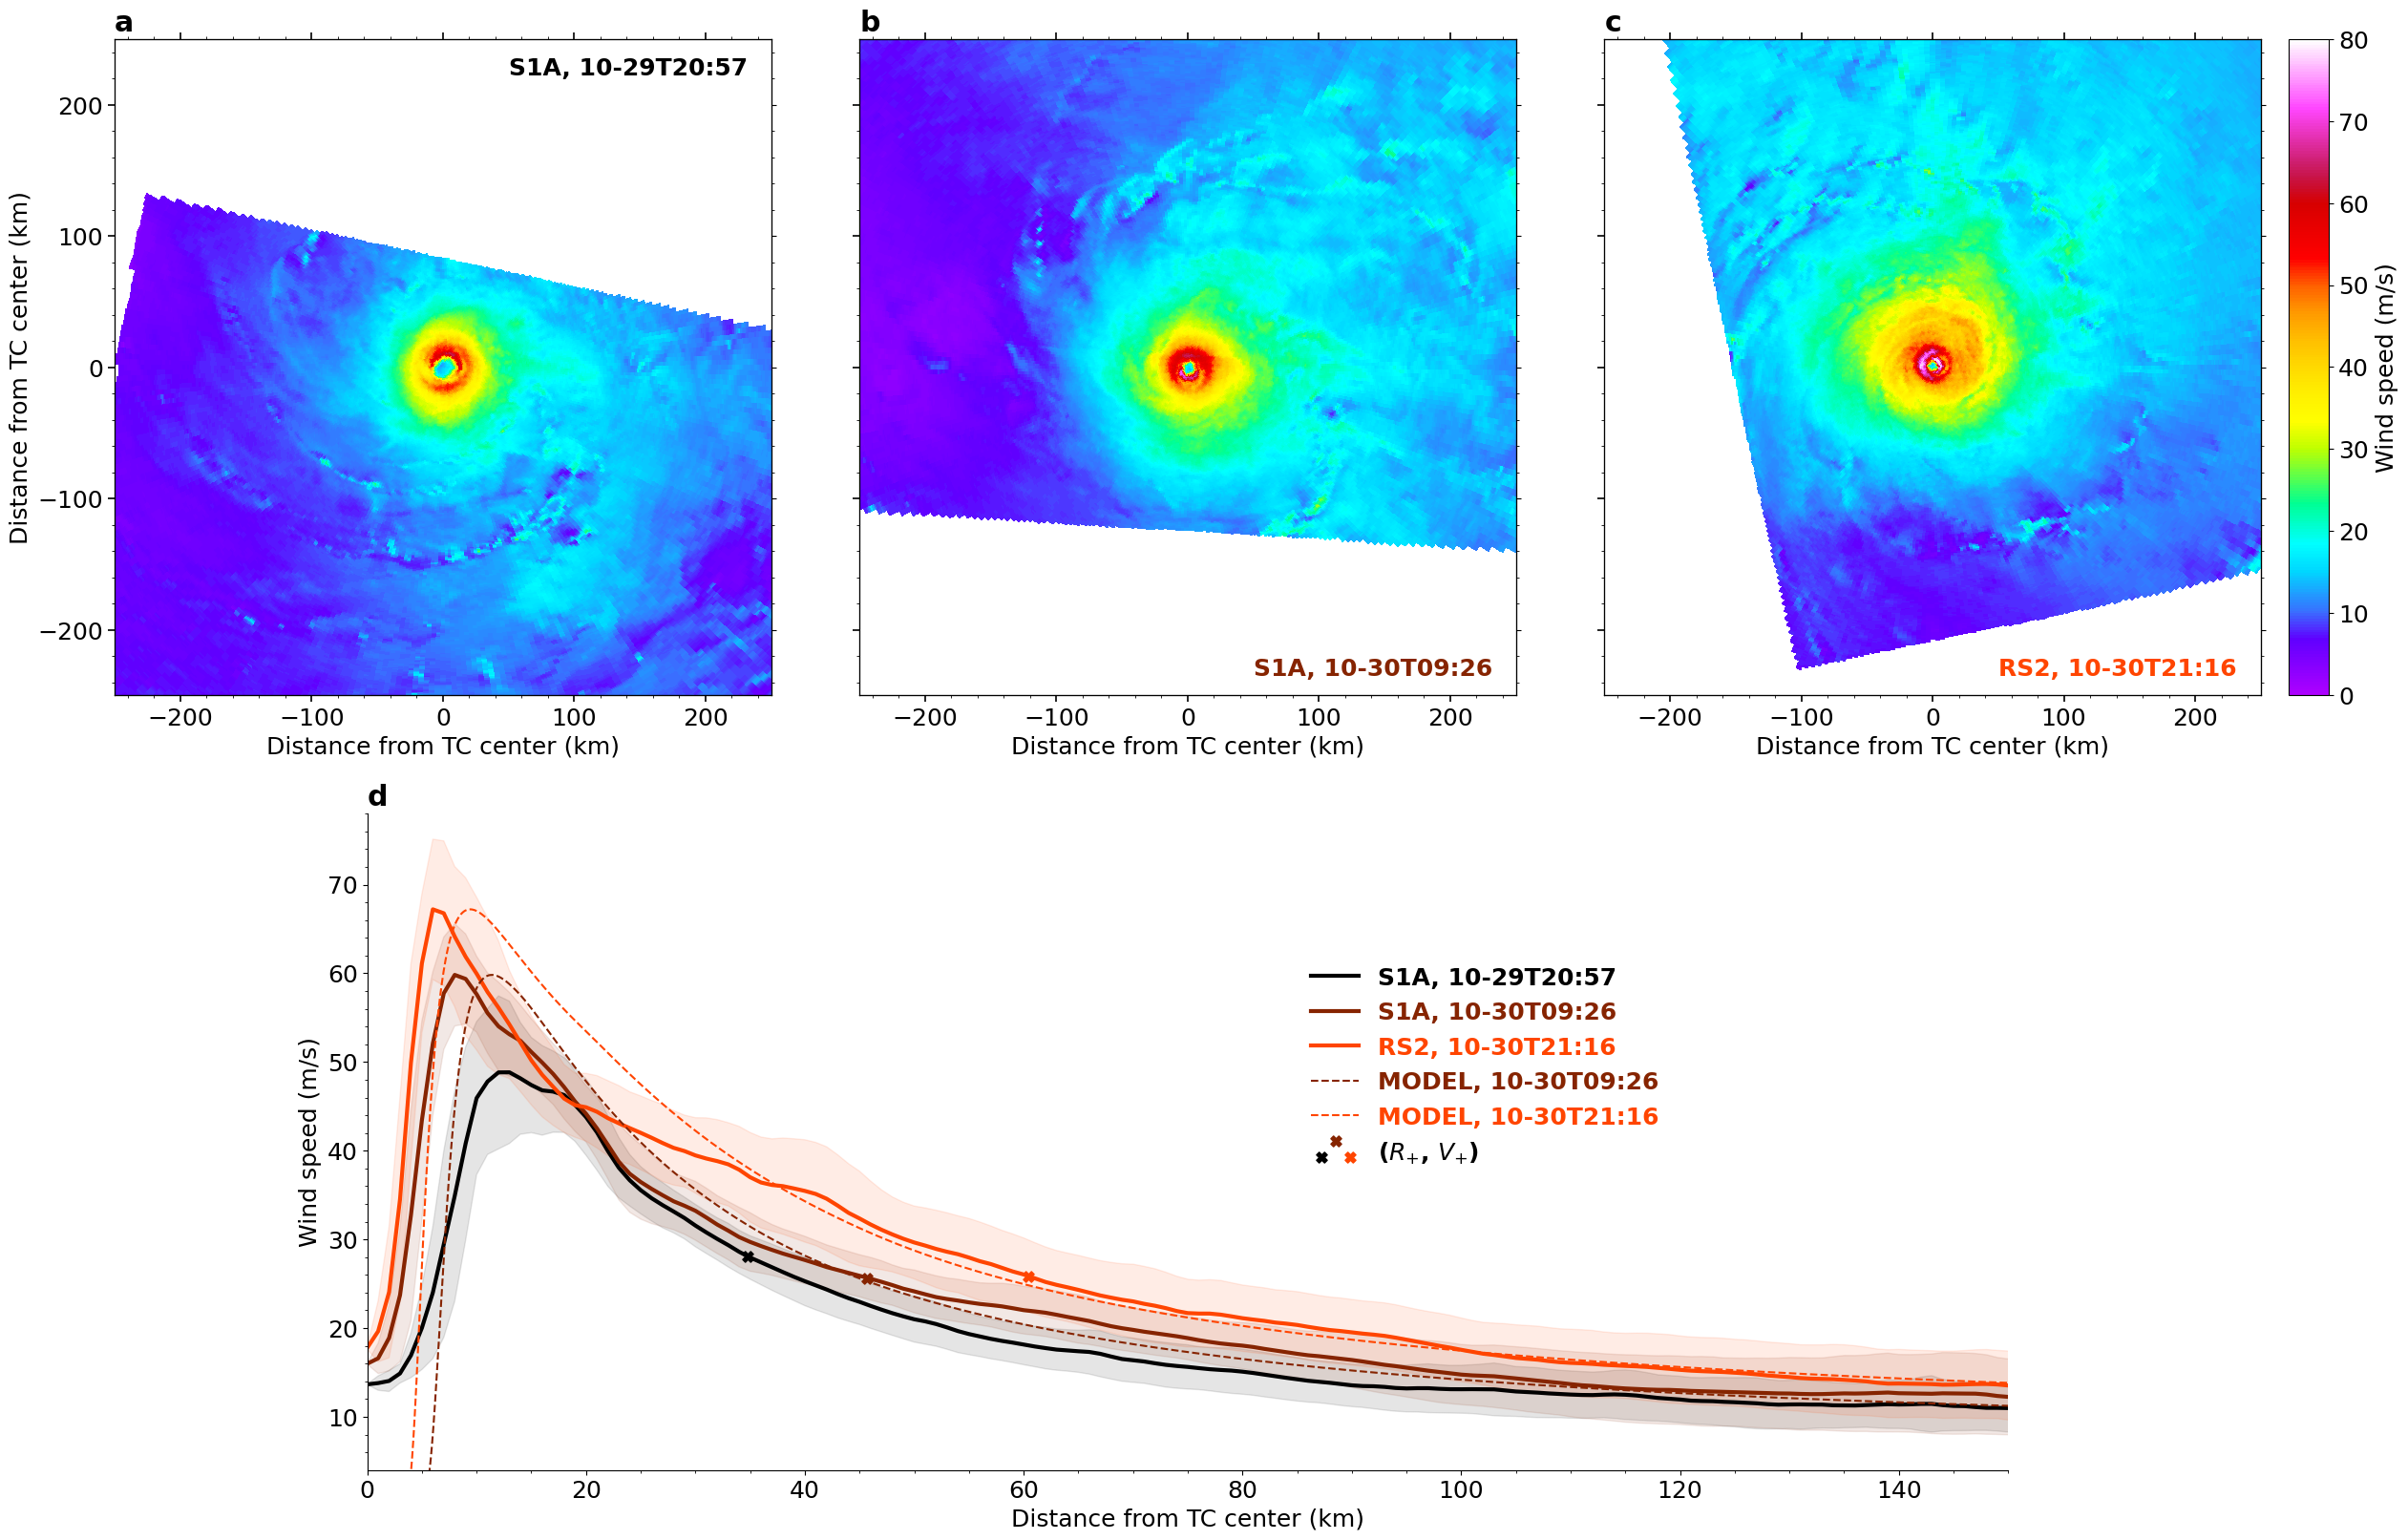

In [24]:
fig        = plt.figure(figsize=(30, 30))
gs         = GridSpec(3, 3, hspace=0.18, wspace=0.02)

cmap       = mpl.cm.get_cmap('PuOr') # Spectral

normalizer = Normalize(0, 80)
ax_lims2D  = 250

##########
# CASE 1 #
##########
p1 = '/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1a-ew-owi-ca-20201029t205631-20201029t205758-000003-0415BC_sw_wp222020_cyclone.nc'
ds = xr.open_dataset(p1).isel(time=0)

### SAR
ax = fig.add_subplot(gs[:1, 0])
ax.set_title('a', weight='bold', loc='left')
ax.text(0.6, 0.945, 'S1A, {}'.format(np.datetime_as_string(ds.time, unit='m')[5:]), transform = ax.transAxes, weight='bold', fontsize=18, c=cm(0))

y_sar, x_sar = pol2cart(ds['rad'], np.deg2rad(ds['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, ds['wind_speed'], cmap=cwnd, norm=normalizer)

ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Distance from TC center (km)')
ax.set_box_aspect(1)
ax.tick_params(axis='both', length=5, width=1.2)
ax.minorticks_on()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=5, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])


##########
# CASE 2 #
##########
p2 = '/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1a-ew-owi-ca-20201030t092540-20201030t092711-000003-0415F8_sw_wp222020_cyclone.nc'
ds = xr.open_dataset(p2).isel(time=0)

### SAR
ax = fig.add_subplot(gs[:1, 1])
ax.set_title('b', weight='bold', loc='left')
ax.text(0.6, 0.03, 'S1A, {}'.format(np.datetime_as_string(ds.time, unit='m')[5:]), transform = ax.transAxes, weight='bold', fontsize=18, c=cm(0.5))

y_sar, x_sar = pol2cart(ds['rad'], np.deg2rad(ds['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, ds['wind_speed'], cmap=cwnd, norm=normalizer)

ax.yaxis.set_ticklabels([])
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_xlabel('Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(axis='both', length=5, width=1.2)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=5, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])


##########
# CASE 3 #
##########
p3 = '/home/arthur/data/cyclobs/Goni_sample/rs2--owi-ca-20201030t211604-20201030t211719-00003-5CB2D_sw_wp222020_geogr_polar.nc'
ds = xr.open_dataset(p3).isel(time=0)

### SAR
ax = fig.add_subplot(gs[:1, 2])
ax.set_title('c', weight='bold', loc='left')
ax.text(0.6, 0.03, 'RS2, {}'.format(np.datetime_as_string(ds.time, unit='m')[5:]), transform = ax.transAxes, weight='bold', fontsize=18, c=cm(0.99))

y_sar, x_sar = pol2cart(ds['rad'], np.deg2rad(ds['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, ds['wind_speed'], cmap=cwnd, norm=normalizer)

ax.yaxis.set_ticklabels([])
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_xlabel('Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(axis='both', length=5, width=1.2)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=5, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.897, 0.651, 0.014, 0.229])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label('Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

############
# PROFILES #
############
ax = fig.add_subplot(gs[1, 0:3])
ax.set_title('d', weight='bold', loc='left')
sensors = ['S1A', 'S1A', 'RS2']

### SAR
for k, p in enumerate([p1, p2, p3]):
    ds = xr.open_dataset(p).isel(time=0)

    spdm_sar = ds.wind_speed.mean(dim='theta', skipna=True)
    spds_sar = ds.wind_speed.std(dim='theta', skipna=True)

    ax.plot(spdm_sar.rad / 1000, spdm_sar, c=cm(k / 2), linewidth=3, label=r'{}, {}'.format(sensors[k], np.datetime_as_string(ds.time, unit='m')[5:]))
    ax.fill_between(spdm_sar.rad / 1000, spdm_sar - spds_sar, spdm_sar + spds_sar, color=cm(k / 2), alpha=0.1)
    
    print('SAR {}'.format(k + 1))
    print('Vmax = {:.1f} m/s'.format(np.nanmax(spdm_sar)))

print('CASE 1: from SAR 0 to SAR 1')
case   = d.where(d.tc_id == 'wp222020', drop=True).isel(pair=0)
print('Rp_ini = {:.1f} km, Rp_fin = {:.1f} km'.format(float(case.Rp_ini / 1000), float(case.Rp_fin / 1000)))
print('Rmax_ini = {:.1f} km, Rmax_fin = {:.1f} km'.format(float(case.rmx_ini / 1000), float(case.rmx_fin / 1000)))
print('Rmax_model = {:.1f} km'.format(rs[np.nanargmax(Vm1)] / 1000))
print('Rp_model = {:.1f} km'.format(float(case.Rp_mod / 1000)))

print('CASE 2: from SAR 1 to SAR 2')
case   = d.where(d.tc_id == 'wp222020', drop=True).isel(pair=1)
print('Rp_ini = {:.1f} km, Rp_fin = {:.1f} km'.format(float(case.Rp_ini / 1000), float(case.Rp_fin / 1000)))
print('Rmax_ini = {:.1f} km, Rmax_fin = {:.1f} km'.format(float(case.rmx_ini / 1000), float(case.rmx_fin / 1000)))
print('Rmax_model = {:.1f} km'.format(rs[np.nanargmax(Vm2)] / 1000))
print('Rp_model = {:.1f} km'.format(float(case.Rp_mod / 1000)))
    
### MODEL
ax.plot(rs / 1000, Vm1, c=cm(0.5), linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(xr.open_dataset(p2).isel(time=0).time, unit='m')[5:]))
ax.plot(rs / 1000, Vm2, c=cm(0.99), linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(xr.open_dataset(p3).isel(time=0).time, unit='m')[5:]))

# R+
# ax.vlines(goni1.Rp_ini / 1000, ymin=0, ymax=goni1.Vp_ini, color=cm(0), zorder=2)
ax.scatter(goni1.Rp_ini / 1000, goni1.Vp_ini, color=cm(0), marker='X', s=65, zorder=2)
# ax.vlines(goni2.Rp_ini / 1000, ymin=0, ymax=goni2.Vp_ini * 1.02, color=cm(0.5), zorder=2)
ax.scatter(goni2.Rp_ini / 1000, goni2.Vp_ini * 1.03, color=cm(0.5), marker='X', s=65, zorder=2)
# ax.vlines(goni2.Rp_fin / 1000, ymin=0, ymax=goni2.Vp_fin * 1.04, color=cm(0.99), zorder=2)
ax.scatter(goni2.Rp_fin / 1000, goni2.Vp_fin * 1.05, color=cm(0.99), marker='X', s=65, zorder=2)
# Scatter legend
ax.scatter(87.2, 39.3, color=cm(0), marker='X', s=65, zorder=2)
ax.scatter(88.5, 41.1, color=cm(0.5), marker='X', s=65, zorder=2)
ax.scatter(89.8, 39.3, color=cm(0.99), marker='X', s=65, zorder=2)
ax.plot([], [], ' ', label=r'($R_{+}$, $V_{+}$)', c=cm(0))

# Grids
ax.set_xlim(0, 150);ax.set_ylim(4, 78)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.8, 0.8), prop=dict(weight='bold'))

if PRMS['sav_fgs']:
    # plt.savefig(PTHS['sav_dir'] + 'intro.pdf', bbox_inches='tight', format='pdf')
    plt.savefig(PTHS['sav_dir'] + 'intro', bbox_inches='tight')

CASE 1
Vmax_ini = 36.2 m/s, Vmax_fin = 44.8 m/s
Rp_ini = 84.2 km, Rp_fin = 77.9 km
Rmax_ini = 40.0 km, Rmax_fin = 42.0 km
Rmax_model = 49.8 km
CASE 2
Vmax_ini = 44.2 m/s, Vmax_fin = 69.2 m/s
Rp_ini = 55.6 km, Rp_fin = 47.5 km
Rmax_ini = 23.0 km, Rmax_fin = 24.0 km
Rmax_model = 21.8 km
CASE 3
Vmax_ini = 52.4 m/s, Vmax_fin = 51.7 m/s
Rp_ini = 37.6 km, Rp_fin = 36.8 km
Rmax_ini = 18.0 km, Rmax_fin = 16.0 km
Rmax_model = 18.1 km
CASE 4
Vmax_ini = 40.6 m/s, Vmax_fin = 30.2 m/s
Rp_ini = 70.1 km, Rp_fin = 72.8 km
Rmax_ini = 41.0 km, Rmax_fin = 42.0 km
Rmax_model = 65.9 km


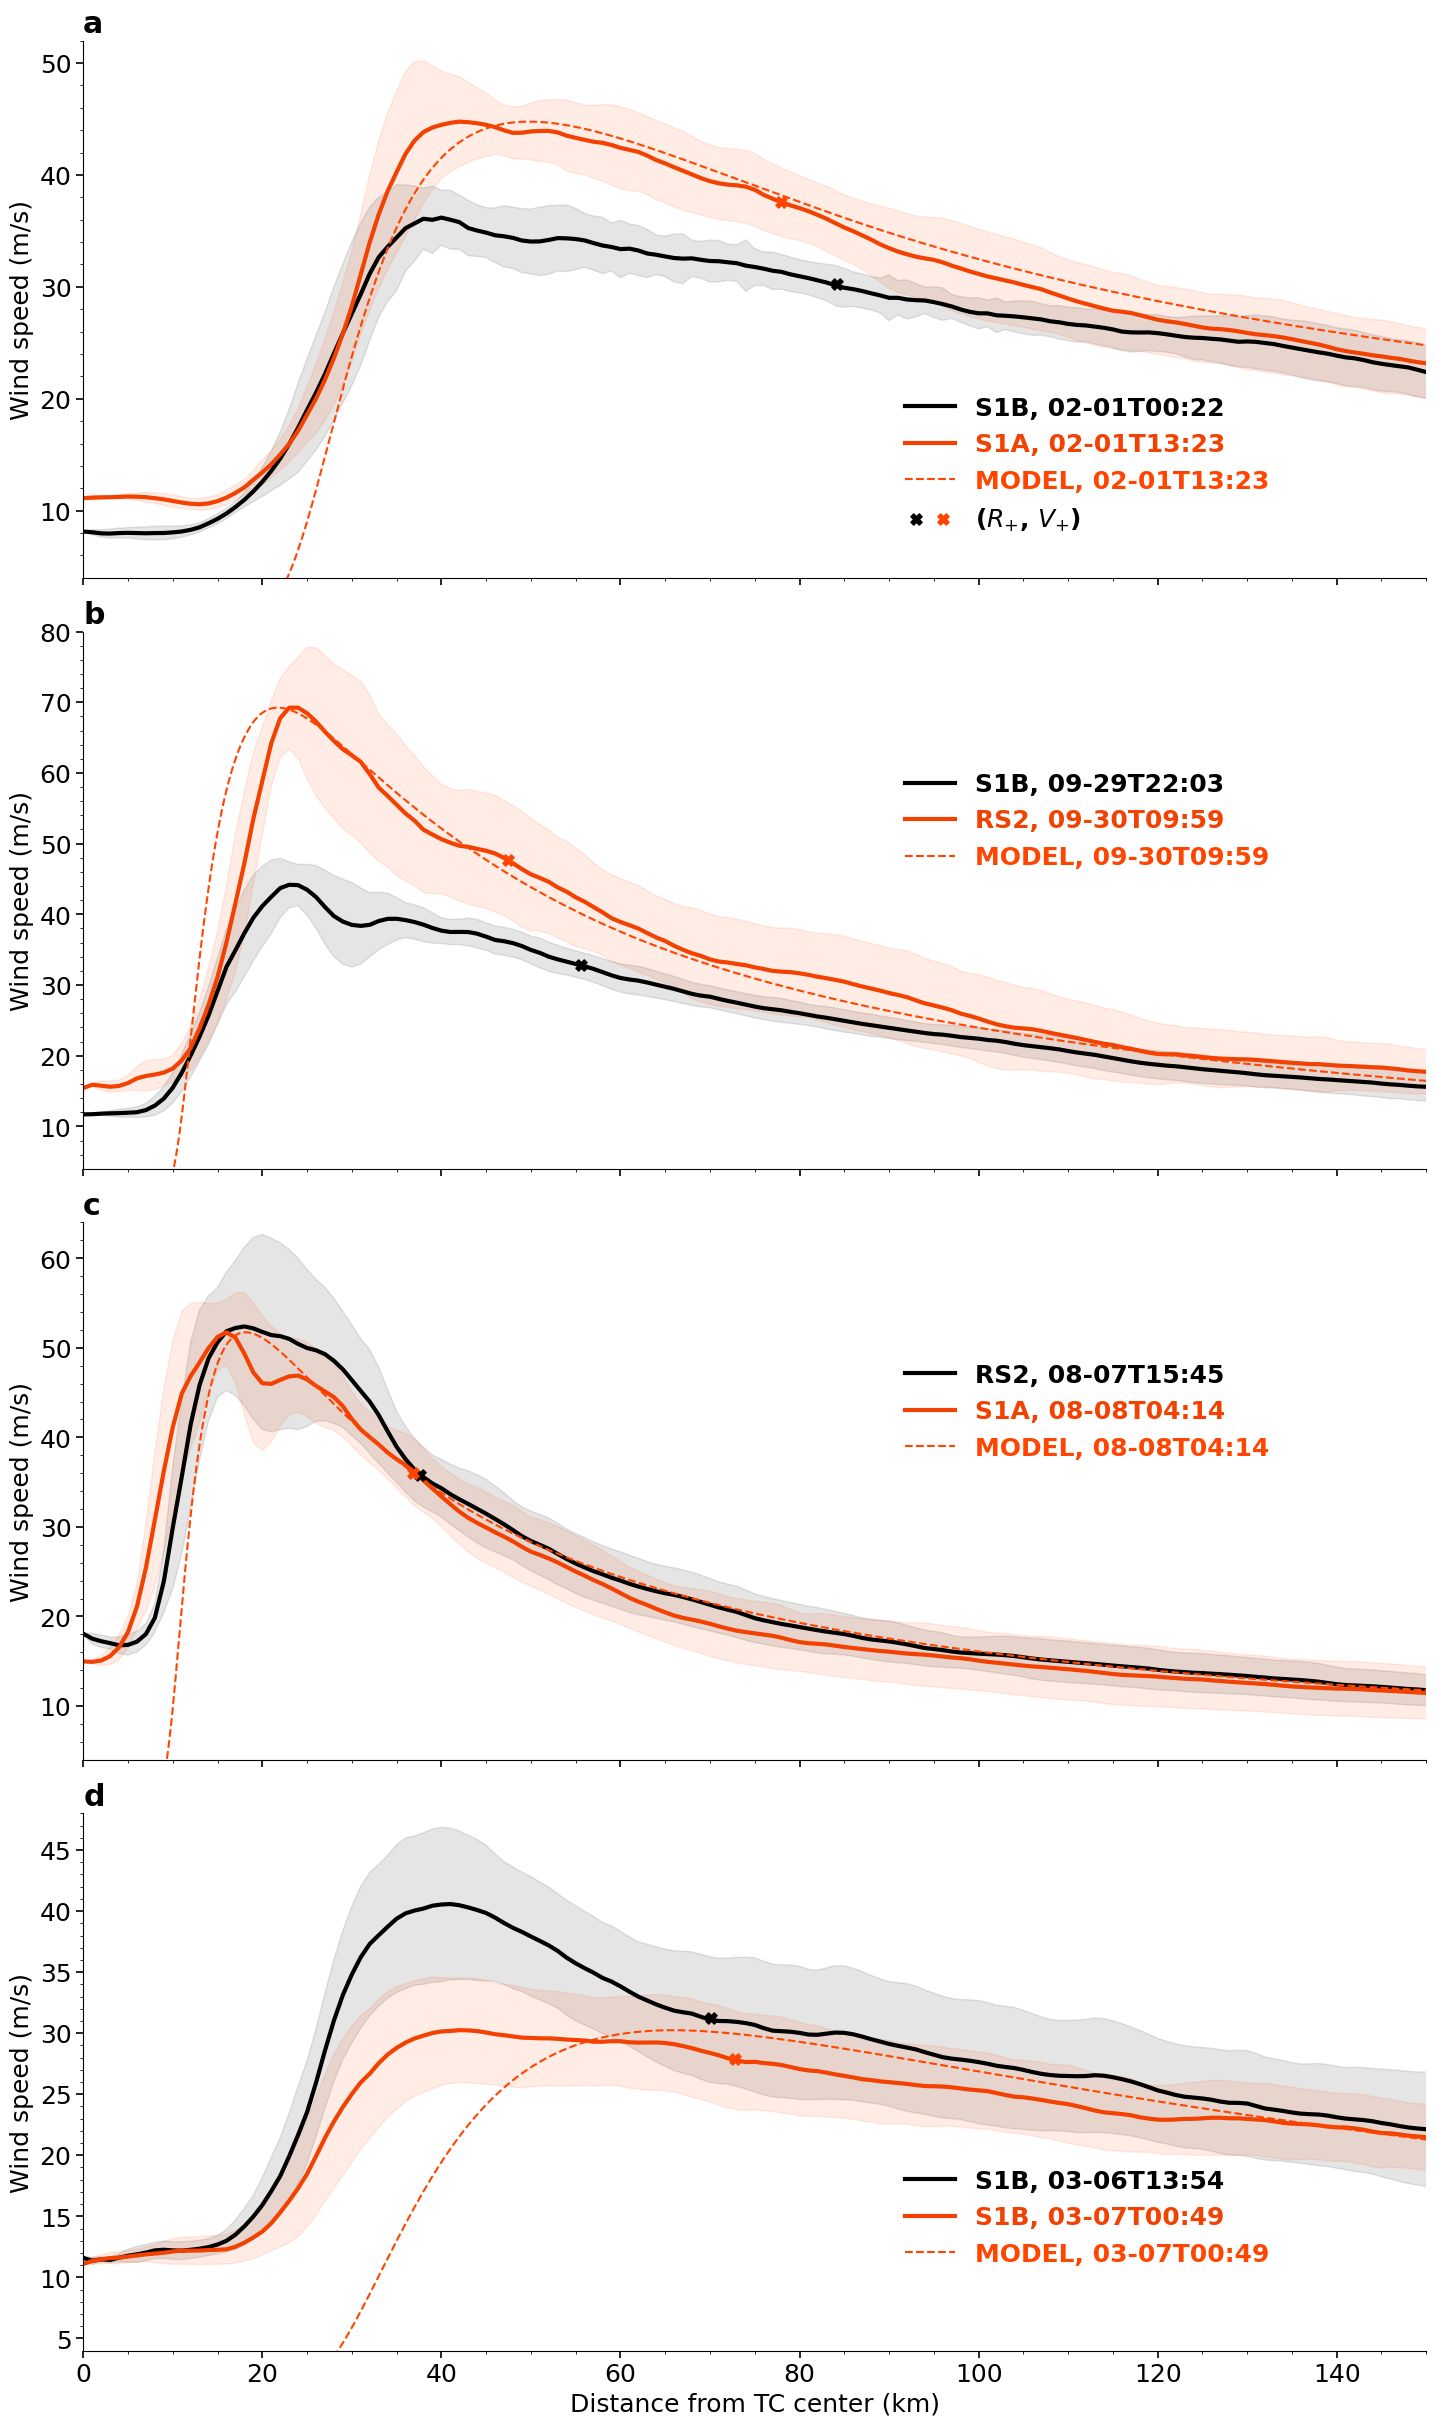

In [12]:
fig        = plt.figure(figsize=(30, 30))
gs         = GridSpec(4, 1, hspace=0.1, wspace=0.02)

ax_lims    = 150

##########
# CEBILE #
##########
ax = fig.add_subplot(gs[0])
ax.set_title('a', weight='bold', loc='left')

### Open data
# SAR
sar_ini  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1b-ew-owi-ca-20180201t002120-20180201t002425-000003-010EF2_sw_sh072018_cyclone.nc').isel(time=0)
sar_fin  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1a-ew-owi-ca-20180201t132219-20180201t132527-000003-022E2F_sw_sh072018_cyclone.nc').isel(time=0)
# Model
tc_id    = 'sh072018'
case     = d.where(d.tc_id == tc_id, drop=True)
tau      = ((1 / float(case.fcor_ini)) / 3600)
dt       = float(case.delta_h) / tau
dsi      = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1     = dsi.isel(time=0)
Vh1      = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm1      = propagate(rs, float(case.a), alpha, Vh1, float(case.fcor_ini), dt=dt)

# SAR profiles
spdm_ini = sar_ini.wind_speed.mean(dim='theta', skipna=True)
spds_ini = sar_ini.wind_speed.std(dim='theta', skipna=True)
spdm_fin = sar_fin.wind_speed.mean(dim='theta', skipna=True)
spds_fin = sar_fin.wind_speed.std(dim='theta', skipna=True)

print('CASE 1')
print('Vmax_ini = {:.1f} m/s, Vmax_fin = {:.1f} m/s'.format(np.nanmax(spdm_ini), np.nanmax(spdm_fin)))
print('Rp_ini = {:.1f} km, Rp_fin = {:.1f} km'.format(float(case.Rp_ini / 1000), float(case.Rp_fin / 1000)))
print('Rmax_ini = {:.1f} km, Rmax_fin = {:.1f} km'.format(float(case.rmx_ini / 1000), float(case.rmx_fin / 1000)))
print('Rmax_model = {:.1f} km'.format(rs[np.nanargmax(Vm1)] / 1000))

# SAR initial
ax.plot(spdm_ini.rad / 1000, spdm_ini, c=cm(0), linewidth=3, label=r'S1B, {}'.format(np.datetime_as_string(sar_ini.time, unit='m')[5:]))
ax.fill_between(spdm_ini.rad / 1000, spdm_ini - spds_ini, spdm_ini + spds_ini, color=cm(0), alpha=0.1)
# SAR final
ax.plot(spdm_fin.rad / 1000, spdm_fin, c=cm(0.9), linewidth=3, label=r'S1A, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))
ax.fill_between(spdm_fin.rad / 1000, spdm_fin - spds_fin, spdm_fin + spds_fin, color=cm(0.99), alpha=0.1)

# Model
ax.plot(rs / 1000, Vm1, c=cm(0.99), linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))

# R+
ax.scatter(case.Rp_ini / 1000, case.Vp_ini * 0.99, color=cm(0),    marker='X', s=65, zorder=2)
ax.scatter(case.Rp_fin / 1000, case.Vp_fin,        color=cm(0.99), marker='X', s=65, zorder=2)
# Scatter legend
ax.scatter(93., 9.3, color=cm(0), marker='X', s=65, zorder=2)
ax.scatter(96., 9.3, color=cm(0.99), marker='X', s=65, zorder=2)
ax.plot([], [], ' ', label=r'($R_{+}$, $V_{+}$)', c=cm(0))

# Grids
ax.set_xlim(0, ax_lims);ax.set_ylim(4, 52)
# ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.xaxis.set_ticklabels([])
ax.tick_params(axis='both', length=5, width=1.2)
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.38), prop=dict(weight='bold'))

##########
#  SAM   #
##########
ax = fig.add_subplot(gs[1])
ax.set_title('b', weight='bold', loc='left')

### Open data
# SAR
sar_ini  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1b-ew-owi-ca-20210929t220202-20210929t220436-000003-037380_sw_al182021_cyclone.nc').isel(time=0)
sar_fin  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/rs2--owi-ca-20210930t095823-20210930t095939-00003-2F7F0_sw_al182021_cyclone.nc').isel(time=0)
# Model
tc_id    = 'al182021'
case     = d.where(d.tc_id == tc_id, drop=True)
tau      = ((1 / float(case.fcor_ini)) / 3600)
dt       = float(case.delta_h) / tau
dsi      = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1     = dsi.isel(time=2)
Vh1      = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm1      = propagate(rs, float(case.a), alpha, Vh1, float(case.fcor_ini), dt=dt)

# SAR profiles
spdm_ini = sar_ini.wind_speed.mean(dim='theta', skipna=True)
spds_ini = sar_ini.wind_speed.std(dim='theta', skipna=True)
spdm_fin = sar_fin.wind_speed.mean(dim='theta', skipna=True)
spds_fin = sar_fin.wind_speed.std(dim='theta', skipna=True)

print('CASE 2')
print('Vmax_ini = {:.1f} m/s, Vmax_fin = {:.1f} m/s'.format(np.nanmax(spdm_ini), np.nanmax(spdm_fin)))
print('Rp_ini = {:.1f} km, Rp_fin = {:.1f} km'.format(float(case.Rp_ini / 1000), float(case.Rp_fin / 1000)))
print('Rmax_ini = {:.1f} km, Rmax_fin = {:.1f} km'.format(float(case.rmx_ini / 1000), float(case.rmx_fin / 1000)))
print('Rmax_model = {:.1f} km'.format(rs[np.nanargmax(Vm1)] / 1000))

# SAR initial
ax.plot(spdm_ini.rad / 1000, spdm_ini, c=cm(0), linewidth=3, label=r'S1B, {}'.format(np.datetime_as_string(sar_ini.time, unit='m')[5:]))
ax.fill_between(spdm_ini.rad / 1000, spdm_ini - spds_ini, spdm_ini + spds_ini, color=cm(0), alpha=0.1)
# SAR final
ax.plot(spdm_fin.rad / 1000, spdm_fin, c=cm(0.9), linewidth=3, label=r'RS2, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))
ax.fill_between(spdm_fin.rad / 1000, spdm_fin - spds_fin, spdm_fin + spds_fin, color=cm(0.99), alpha=0.1)

# Model
ax.plot(rs / 1000, Vm1, c=cm(0.99), linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))

# R+
ax.scatter(case.Rp_ini / 1000, case.Vp_ini * 1.01, color=cm(0),    marker='X', s=65, zorder=2)
ax.scatter(case.Rp_fin / 1000, case.Vp_fin * 0.99, color=cm(0.99), marker='X', s=65, zorder=2)

# Grids
ax.set_xlim(0, ax_lims);ax.set_ylim(4, 80)
# ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.xaxis.set_ticklabels([])
ax.tick_params(axis='both', length=5, width=1.2)
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.78), prop=dict(weight='bold'))

##########
# HECTOR #
##########
ax = fig.add_subplot(gs[2])
ax.set_title('c', weight='bold', loc='left')

### Open data
# SAR
sar_ini  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/rs2--owi-ca-20180807t154512-20180807t154628-00003-07134_sw_ep102018_cyclone.nc').isel(time=0)
sar_fin  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1a-ew-owi-ca-20180808t041303-20180808t041507-000003-0283BF_sw_ep102018_cyclone.nc').isel(time=0)
# Model
tc_id    = 'ep102018'
case     = d.where(d.tc_id == tc_id, drop=True).isel(pair=1)
tau      = ((1 / float(case.fcor_ini)) / 3600)
dt       = float(case.delta_h) / tau
dsi      = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1     = dsi.isel(time=3)
Vh1      = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm1      = propagate(rs, float(case.a), alpha, Vh1, float(case.fcor_ini), dt=dt)

# SAR profiles
spdm_ini = sar_ini.wind_speed.mean(dim='theta', skipna=True)
spds_ini = sar_ini.wind_speed.std(dim='theta', skipna=True)
spdm_fin = sar_fin.wind_speed.mean(dim='theta', skipna=True)
spds_fin = sar_fin.wind_speed.std(dim='theta', skipna=True)

print('CASE 3')
print('Vmax_ini = {:.1f} m/s, Vmax_fin = {:.1f} m/s'.format(np.nanmax(spdm_ini), np.nanmax(spdm_fin)))
print('Rp_ini = {:.1f} km, Rp_fin = {:.1f} km'.format(float(case.Rp_ini / 1000), float(case.Rp_fin / 1000)))
print('Rmax_ini = {:.1f} km, Rmax_fin = {:.1f} km'.format(float(case.rmx_ini / 1000), float(case.rmx_fin / 1000)))
print('Rmax_model = {:.1f} km'.format(rs[np.nanargmax(Vm1)] / 1000))

# SAR initial
ax.plot(spdm_ini.rad / 1000, spdm_ini, c=cm(0), linewidth=3, label=r'RS2, {}'.format(np.datetime_as_string(sar_ini.time, unit='m')[5:]))
ax.fill_between(spdm_ini.rad / 1000, spdm_ini - spds_ini, spdm_ini + spds_ini, color=cm(0), alpha=0.1)
# SAR final
ax.plot(spdm_fin.rad / 1000, spdm_fin, c=cm(0.9), linewidth=3, label=r'S1A, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))
ax.fill_between(spdm_fin.rad / 1000, spdm_fin - spds_fin, spdm_fin + spds_fin, color=cm(0.99), alpha=0.1)

# Model
ax.plot(rs / 1000, Vm1, c=cm(0.99), linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))

# R+
ax.scatter(case.Rp_ini / 1000, case.Vp_ini * 0.98, color=cm(0),    marker='X', s=65, zorder=2)
ax.scatter(case.Rp_fin / 1000, case.Vp_fin * 1.1, color=cm(0.99), marker='X', s=65, zorder=2)

# Grids
ax.set_xlim(0, ax_lims);ax.set_ylim(4, 64)
# ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.xaxis.set_ticklabels([])
ax.tick_params(axis='both', length=5, width=1.2)
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.78), prop=dict(weight='bold'))

##########
# HALEH  #
##########
ax = fig.add_subplot(gs[3])
ax.set_title('d', weight='bold', loc='left')

### Open data
# SAR
sar_ini  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1b-ew-owi-ca-20190306t135326-20190306t135533-000003-01C808_sw_sh172019_cyclone.nc').isel(time=0)
sar_fin  = xr.open_dataset('/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1b-ew-owi-ca-20190307t004754-20190307t005102-000003-01C845_sw_sh172019_cyclone.nc').isel(time=0)
# Model
tc_id    = 'sh172019'
case     = d.where(d.tc_id == tc_id, drop=True)
tau      = ((1 / float(case.fcor_ini)) / 3600)
dt       = float(case.delta_h) / tau
dsi      = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1     = dsi.isel(time=1)
Vh1      = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm1      = propagate(rs, float(case.a), alpha, Vh1, float(case.fcor_ini), dt=dt)

# SAR profiles
spdm_ini = sar_ini.wind_speed.mean(dim='theta', skipna=True)
spds_ini = sar_ini.wind_speed.std(dim='theta', skipna=True)
spdm_fin = sar_fin.wind_speed.mean(dim='theta', skipna=True)
spds_fin = sar_fin.wind_speed.std(dim='theta', skipna=True)

print('CASE 4')
print('Vmax_ini = {:.1f} m/s, Vmax_fin = {:.1f} m/s'.format(np.nanmax(spdm_ini), np.nanmax(spdm_fin)))
print('Rp_ini = {:.1f} km, Rp_fin = {:.1f} km'.format(float(case.Rp_ini / 1000), float(case.Rp_fin / 1000)))
print('Rmax_ini = {:.1f} km, Rmax_fin = {:.1f} km'.format(float(case.rmx_ini / 1000), float(case.rmx_fin / 1000)))
print('Rmax_model = {:.1f} km'.format(rs[np.nanargmax(Vm1)] / 1000))

# SAR initial
ax.plot(spdm_ini.rad / 1000, spdm_ini, c=cm(0), linewidth=3, label=r'S1B, {}'.format(np.datetime_as_string(sar_ini.time, unit='m')[5:]))
ax.fill_between(spdm_ini.rad / 1000, spdm_ini - spds_ini, spdm_ini + spds_ini, color=cm(0), alpha=0.1)
# SAR final
ax.plot(spdm_fin.rad / 1000, spdm_fin, c=cm(0.9), linewidth=3, label=r'S1B, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))
ax.fill_between(spdm_fin.rad / 1000, spdm_fin - spds_fin, spdm_fin + spds_fin, color=cm(0.99), alpha=0.1)

# Model
ax.plot(rs / 1000, Vm1, c=cm(0.99), linestyle='dashed', label='MODEL, {}'.format(np.datetime_as_string(sar_fin.time, unit='m')[5:]))

# R+
ax.scatter(case.Rp_ini / 1000, case.Vp_ini * 0.92, color=cm(0),    marker='X', s=65, zorder=2)
ax.scatter(case.Rp_fin / 1000, case.Vp_fin * 0.98, color=cm(0.99), marker='X', s=65, zorder=2)

# Grids
ax.set_xlim(0, ax_lims);ax.set_ylim(4, 48)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
# ax.xaxis.set_ticklabels([])
ax.tick_params(axis='both', length=5, width=1.2)
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.38), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'profiles.pdf', bbox_inches='tight', format='pdf')

if PRMS['sav_fgs']:
    # plt.savefig(PTHS['sav_dir'] + 'profiles.pdf', bbox_inches='tight', format='pdf')
    plt.savefig(PTHS['sav_dir'] + 'profiles', bbox_inches='tight')

In [13]:
# ##########
# # ERRORS #
# ##########
# fig        = plt.figure(figsize=(15, 7))
# gs         = GridSpec(1, 2, hspace=0.18, wspace=0.1)

# ax_lim     = 10

# c_min      = 0.4
# c_max      = 1.6
# cmap       = mpl.cm.get_cmap('coolwarm')

# #########
# # MODEL #
# #########
# ax  = fig.add_subplot(gs[0])
# ax.set_title('a', weight='bold', loc='left')
# ax.text(0.6, 0.945, 'Model', transform = ax.transAxes, weight='bold', fontsize=18)

# # Mean and std
# ax.plot(r_ref, d.mean(dim='pair').rel_err * 100, linewidth=3, c='k')
# ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 + d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed')
# ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 - d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed')

# # Individual errors
# for p in range(len(d.pair)):
#     ax.plot(r_ref, d.isel(pair=p).rel_err * 100, c=cmap((d.isel(pair=p).vmx_fin / d.isel(pair=p).vmx_ini - c_min) / (c_max - c_min)), alpha=0.5, zorder=0)
    
# # Rmax
# ax.axvline(1, c='k', linewidth=1)
# ax.axhline(0, c='k', linewidth=1)
        
# # Grid, limits
# ax.set_xlim(-0.1, ax_lim);ax.set_ylim(-75, 75)
# ax.minorticks_on();ax.tick_params(length=7, width=1.2)
# ax.spines[['right', 'top']].set_visible(False)
# ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
# # ax.legend(frameon=False, loc='lower right')

# #########
# # PERS. #
# #########
# ### PERSISTENCE
# ax  = fig.add_subplot(gs[1])
# ax.set_title('b', weight='bold', loc='left')
# ax.text(0.6, 0.945, 'Persistence', transform = ax.transAxes, weight='bold', fontsize=18)

# # Mean and std
# ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
# ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 + d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
# ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 - d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed')

# # Individual errors
# for p in range(len(d.pair)):
#     ax.plot(r_ref, d.isel(pair=p).rel_err_prs * 100, c=cmap((d.isel(pair=p).vmx_fin / d.isel(pair=p).vmx_ini - c_min) / (c_max - c_min)), alpha=0.5, zorder=0)
    
# # Rmax
# ax.axvline(1, c='k', linewidth=1)
# ax.axhline(0, c='k', linewidth=1)
        
# # Grid, limits
# ax.set_xlim(-0.1, ax_lim);ax.set_ylim(-75, 75)
# ax.minorticks_on();ax.tick_params(length=7, width=1.2)
# ax.spines[['right', 'top']].set_visible(False)
# ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$')
# # ax.set_ylabel(r'Relative error (%)')
# ax.set_yticklabels([])
# ax.legend(frameon=False, loc='lower right')

# # Colorbar
# norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
# sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
# cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
# cbar.formatter.set_useMathText(True)
# cbar.set_label(r'$\frac{V_{max, final}}{V_{max, initial}}$', rotation=90)
# cbar.ax.get_yaxis().labelpad=8

# # plt.savefig(PTHS['sav_dir'] + 'error_model_persistence.pdf', bbox_inches='tight', format='pdf')

# if PRMS['sav_fgs']:
#     plt.savefig(PTHS['sav_dir'] + 'error_model_persistence.pdf', bbox_inches='tight', format='pdf')

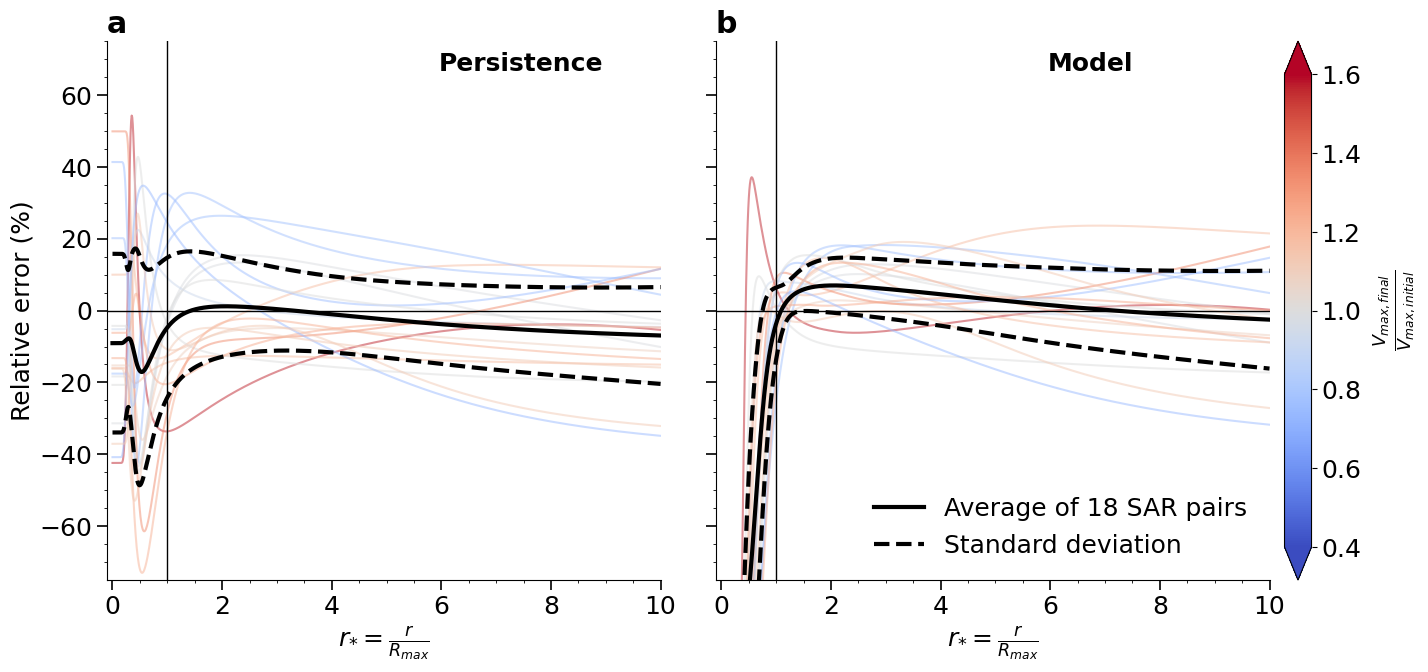

In [14]:
##########
# ERRORS #
##########
fig        = plt.figure(figsize=(15, 7))
gs         = GridSpec(1, 2, hspace=0.18, wspace=0.1)

ax_lim     = 10

c_min      = 0.4
c_max      = 1.6
cmap       = mpl.cm.get_cmap('coolwarm')

#########
# PERS. #
#########
### PERSISTENCE
ax  = fig.add_subplot(gs[0])
ax.set_title('a', weight='bold', loc='left')
ax.text(0.6, 0.945, 'Persistence', transform = ax.transAxes, weight='bold', fontsize=18)

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100, linewidth=3, c='k')
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 + d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed')
ax.plot(r_ref, d.mean(dim='pair').rel_err_prs * 100 - d.std(dim='pair').rel_err_prs * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err_prs * 100, c=cmap((d.isel(pair=p).vmx_fin / d.isel(pair=p).vmx_ini - c_min) / (c_max - c_min)), alpha=0.5, zorder=0)
    
# Rmax
ax.axvline(1, c='k', linewidth=1)
ax.axhline(0, c='k', linewidth=1)
        
# Grid, limits
ax.set_xlim(-0.1, ax_lim);ax.set_ylim(-75, 75)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$')
ax.set_ylabel(r'Relative error (%)')

#########
# MODEL #
#########
ax  = fig.add_subplot(gs[1])
ax.set_title('b', weight='bold', loc='left')
ax.text(0.6, 0.945, 'Model', transform = ax.transAxes, weight='bold', fontsize=18)

# Mean and std
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(d.pair)))
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 + d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, d.mean(dim='pair').rel_err * 100 - d.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(d.pair)):
    ax.plot(r_ref, d.isel(pair=p).rel_err * 100, c=cmap((d.isel(pair=p).vmx_fin / d.isel(pair=p).vmx_ini - c_min) / (c_max - c_min)), alpha=0.5, zorder=0)
    
# Rmax
ax.axvline(1, c='k', linewidth=1)
ax.axhline(0, c='k', linewidth=1)
        
# Grid, limits
ax.set_xlim(-0.1, ax_lim);ax.set_ylim(-75, 75)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$')
# ax.set_ylabel(r'Relative error (%)')
ax.set_yticklabels([])
ax.legend(frameon=False, loc='lower right')

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$\frac{V_{max, final}}{V_{max, initial}}$', rotation=90)
cbar.ax.get_yaxis().labelpad=8

# plt.savefig(PTHS['sav_dir'] + 'error_model_persistence.pdf', bbox_inches='tight', format='pdf')

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_model_persistence.pdf', bbox_inches='tight', format='pdf')

In [15]:
(d.rel_err * 100).max(dim='r*')

<xarray.DataArray 'rel_err' (pair: 18)>
array([23.64458769, 37.10363493, 12.88970017, 10.16077628, 18.16069593,
        2.85315702,  8.21177476, 17.80840854, 14.62400614, 14.68740129,
       18.25004144,  9.55459233,  3.83854346,  5.38493074, 15.43291842,
        0.37587987, 13.32709565, 19.11025478])
Dimensions without coordinates: pair

In [16]:
d.tc_id

<xarray.DataArray 'tc_id' (pair: 18)>
array(['al122021', 'al182021', 'ep102018', 'ep102018', 'ep102018',
       'ep132016', 'ep142018', 'ep162018', 'ep182020', 'ep182020',
       'ep212018', 'ep212018', 'sh072018', 'sh172019', 'sh192021',
       'sh222019', 'wp222020', 'wp222020'], dtype=object)
Dimensions without coordinates: pair

In [17]:
d.Hp

<xarray.DataArray 'Hp' (pair: 18)>
array([11690.77400488, 64480.52988404, 26980.786525  , 27400.80650867,
       16579.42879783, 28350.34703835, 36630.90234852, 54232.95453151,
       22536.81946911, 16406.79715472, 16241.25233279, 17752.5559082 ,
       25014.4632328 ,  6364.10490699, 35650.05667094,  8855.01000723,
       51840.50558499, 76255.81606634])
Dimensions without coordinates: pair

In [19]:
d.Rp_ini

<xarray.DataArray 'Rp_ini' (pair: 18)>
array([84450., 55640., 38250., 37570., 37420., 42740., 48020., 47010.,
       57860., 52030., 80160., 76590., 84180., 70130., 49480., 88510.,
       34780., 45680.])
Dimensions without coordinates: pair

In [20]:
d.tc_id

<xarray.DataArray 'tc_id' (pair: 18)>
array(['al122021', 'al182021', 'ep102018', 'ep102018', 'ep102018',
       'ep132016', 'ep142018', 'ep162018', 'ep182020', 'ep182020',
       'ep212018', 'ep212018', 'sh072018', 'sh172019', 'sh192021',
       'sh222019', 'wp222020', 'wp222020'], dtype=object)
Dimensions without coordinates: pair

In [22]:
d.Rp_ini / d.rmx_ini

<xarray.DataArray (pair: 18)>
array([1.34047619, 2.41913043, 2.125     , 2.08722222, 2.33875   ,
       2.137     , 3.20133333, 1.95875   , 2.41083333, 2.16791667,
       1.90857143, 2.07      , 2.1045    , 1.7104878 , 2.60421053,
       1.34106061, 2.67538462, 5.71      ])
Dimensions without coordinates: pair

In [14]:
### Compute h+ for all the SAR dataset

dsg['Rp'] = dsg.distance_to_coast.copy(deep=True) * np.nan
dsg['Vp'] = dsg.distance_to_coast.copy(deep=True) * np.nan
dsg['hp'] = dsg.distance_to_coast.copy(deep=True) * np.nan

for t in tqdm(range(len(dsg.time))):
    ds     = dsg.isel(time=t)
    Vh     = holland_profile(rs,     float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))
    Rp, Vp = compute_RV_plus(rs, Vh, float(abs(coriolis(ds.lat_center))), PRMS['n'])
    dMp    = np.gradient(rs * Vh + 0.5 * float(abs(coriolis(ds.lat_center))) * (rs ** 2), dr)[rs >= Rp][0] # dM/dr at R+
    
    dsg['Rp'][t] = Rp
    dsg['Vp'][t] = Vp
    
    num  = Cd_plus * Rp * (Vp ** 2)
    a    = np.log(Vp / (float(abs(coriolis(ds.lat_center))) * Rp))
    ubar = Vp * (1 - np.exp(-a)) / (2 * a)
    den  = ubar * dMp

    dsg['hp'][t] = num / den

  0%|          | 0/162 [00:00<?, ?it/s]

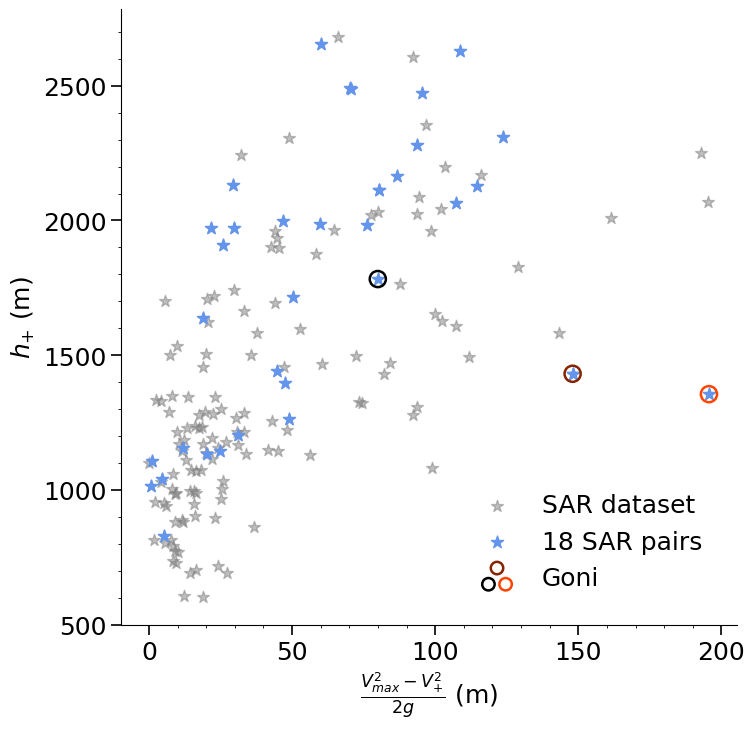

In [15]:
###########
# BL HGTS #
###########
fig, ax = plt.subplots(figsize=(12, 8))

# Plot
sm = ax.scatter((dsg.Vmax_1D ** 2 - dsg.Vp ** 2) / 20, dsg.hp, marker='*', s=80, c='gray', alpha=0.5, label='SAR dataset')
ax.scatter((d.vmx_ini ** 2 - d.Vp_ini ** 2) / 20, d.hp, marker='*', s=85, c='cornflowerblue', label='{} SAR pairs'.format(len(d.pair)))
ax.scatter((d.vmx_fin ** 2 - d.Vp_fin ** 2) / 20, d.hp_fin, marker='*', s=85, c='cornflowerblue')
# Goni
ax.scatter((goni1.vmx_ini ** 2 - goni1.Vp_ini ** 2) / 20, goni1.hp,     marker='o', s=135, facecolor='None', edgecolor=cm(0),    linewidth=1.8)
ax.scatter((goni2.vmx_ini ** 2 - goni2.Vp_ini ** 2) / 20, goni2.hp,     marker='o', s=135, facecolor='None', edgecolor=cm(0.5),  linewidth=1.8)
ax.scatter((goni2.vmx_fin ** 2 - goni2.Vp_fin ** 2) / 20, goni2.hp_fin, marker='o', s=135, facecolor='None', edgecolor=cm(0.99), linewidth=1.8)

# Goni legend
ax.scatter(118.6, 650, marker='o', s=80, facecolor='None', edgecolor=cm(0), linewidth=1.8)
ax.scatter(121.6, 710, marker='o', s=80, facecolor='None', edgecolor=cm(0.5), linewidth=1.8)
ax.scatter(124.6, 650, marker='o', s=80, facecolor='None', edgecolor=cm(0.99), linewidth=1.8)
ax.plot([], [], ' ', label=r'Goni', c=cm(0))

# Grid, legend
ax.legend(loc='lower right', frameon=False, bbox_to_anchor=(0.98, 0.02))
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.set_box_aspect(1)
ax.set_ylabel(r'$h_{+}$ (m)')
ax.set_xlabel(r'$\frac{V_{max}^2 - V_{+}^2}{2 g}$ (m)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)

# plt.savefig(PTHS['sav_dir'] + 'h_plus.pdf', bbox_inches='tight', format='pdf')

if PRMS['sav_fgs']:
    plt.savefig(PTHS['save_dir'] + 'h_plus.pdf', bbox_inches='tight', format='pdf')

In [24]:
### GONI: MODEL
tc_id = 'wp222020'
goni  = d.where(d.tc_id == tc_id, drop=True)
goni1 = goni.isel(pair=0)
goni2 = goni.isel(pair=1)

# First case
tau   = ((1 / float(goni1.fcor_ini)) / 3600)
dt    = float(goni1.delta_h) / tau
dsi   = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1  = dsi.isel(time=0)
Vh1   = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm1   = propagate(rs, float(goni1.a), alpha, Vh1, float(goni1.fcor_ini), dt=dt)

# Second case
tau   = ((1 / float(goni2.fcor_ini)) / 3600)
dt    = float(goni2.delta_h) / tau
dsi   = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi2  = dsi.isel(time=1)
Vh2   = holland_profile(rs, float(abs(dsi2.lat_center)), float(dsi2.pn_hol), float(dsi2.pc_hol), float(dsi2.Vmin_hol), float(dsi2.Rmax_hol), float(dsi2.Vmax_hol))
Vm2   = propagate(rs, float(goni2.a), alpha, Vh2, float(goni2.fcor_ini), dt=dt)

In [25]:
### Open SMAP on Goni
smap    = xr.open_dataset('/home/arthur/data/radiometer/KNMI/product_JF_rotated_filtered/POLAR/2020/WP222020/POL_RSS_smap_wind_daily_2020_10_30_v01.0.nc')

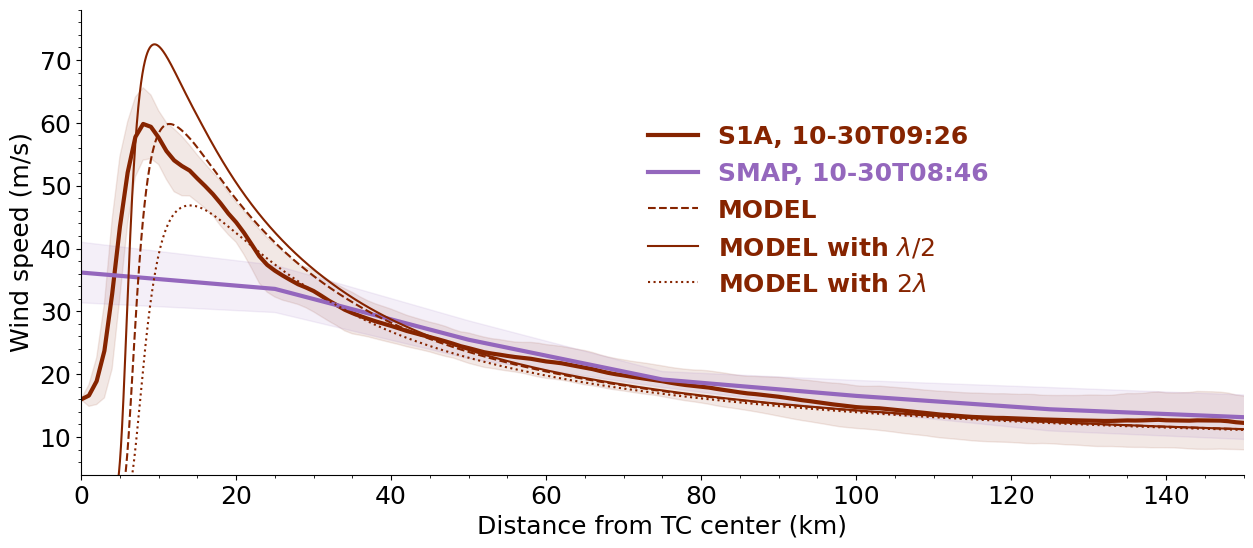

In [26]:
fig, ax = plt.subplots(figsize=(15, 7))

# SAR 
ds       = xr.open_dataset(p2).isel(time=0)
spdm_sar = ds.wind_speed.mean(dim='theta', skipna=True)
spds_sar = ds.wind_speed.std(dim='theta', skipna=True)
ax.plot(spdm_sar.rad / 1000, spdm_sar, c=cm(0.5), linewidth=3, label=r'{}, {}'.format(sensors[1], np.datetime_as_string(ds.time, unit='m')[5:]))
ax.fill_between(spdm_sar.rad / 1000, spdm_sar - spds_sar, spdm_sar + spds_sar, color=cm(0.5), alpha=0.1)

# RAD
spdm_rad = smap.wind_speed.mean(dim='theta', skipna=True)
spds_rad = smap.wind_speed.std(dim='theta', skipna=True)
ax.plot(smap.rad, spdm_rad, c='tab:purple', linewidth=3, label=r'SMAP, {}'.format(np.datetime_as_string(smap.acquisition_time, unit='m')[5:]))
ax.fill_between(smap.rad, spdm_rad - spds_rad, spdm_rad + spds_rad, color='tab:purple', alpha=0.1)

# MODEL
ax.plot(rs / 1000, Vm1, c=cm(0.5), linestyle='dashed', label='MODEL')
ax.plot(rs / 1000, propagate(rs, float(goni1.a) * 2, alpha, Vh1, float(goni1.fcor_ini), dt=dt), c=cm(0.5), label=r'MODEL with $\lambda/2$')
ax.plot(rs / 1000, propagate(rs, float(goni1.a) * 0.5, alpha, Vh1, float(goni1.fcor_ini), dt=dt), c=cm(0.5), linestyle='dotted', label=r'MODEL with $2\lambda$')

# Grids
ax.set_xlim(0, 150);ax.set_ylim(4, 78)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.8, 0.8), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'low_resolution.pdf', bbox_inches='tight', format='pdf')

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'low_resolution.pdf', bbox_inches='tight', format='pdf')

In [18]:
### Collocations between radiometer and one of the pairs:
# Hector, 08-11 at 0530 (both SMAP and SMOS), ep102018

# Marie, 10-02 at 0223 (SMOS), ep182020
# Marie, 10-03 at 1420 (SMOS)

# Sergio, 10-04 at 0211 (SMOS), ep212018

# Cebile, 02-01 at 1310 (SMOS), nice one, sh072018

# Haleh, 03-07 at 0049 (SMAP), also nice, sh172019

In [19]:
### MARIE
tc_id = 'ep182020'
case  = d.where(d.tc_id == tc_id, drop=True).isel(pair=1)

tau   = ((1 / float(case.fcor_ini)) / 3600)
dt    = float(case.delta_h) / tau
dsi   = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1  = dsi.isel(time=2)
Vh    = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm    = propagate(rs, float(case.a), alpha, Vh, float(case.fcor_ini), dt=dt)

rad   = xr.open_dataset('/home/arthur/data/radiometer/KNMI/product_JF_rotated_filtered/POLAR/2020/EP182020/POL_SM_REPR_MIR_SCNFSW_20201003T134830_20201003T144230_300_321_7.nc')

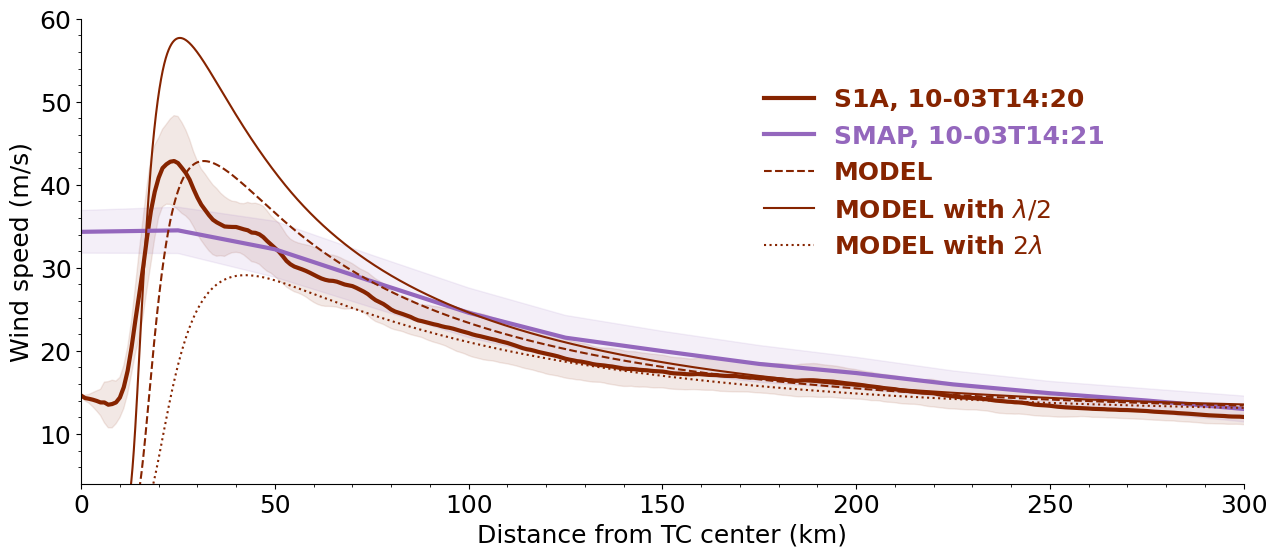

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))

# SAR 
ds = dsi.isel(time=3)
spdm_sar = ds.wind_speed.mean(dim='theta', skipna=True)
spds_sar = ds.wind_speed.std(dim='theta', skipna=True)
ax.plot(spdm_sar.rad / 1000, spdm_sar, c=cm(0.5), linewidth=3, label=r'{}, {}'.format(sensors[1], np.datetime_as_string(ds.time, unit='m')[5:]))
ax.fill_between(spdm_sar.rad / 1000, spdm_sar - spds_sar, spdm_sar + spds_sar, color=cm(0.5), alpha=0.1)

# RAD
spdm_rad = rad.wind_speed.mean(dim='theta', skipna=True)
spds_rad = rad.wind_speed.std(dim='theta', skipna=True)
ax.plot(rad.rad, spdm_rad, c='tab:purple', linewidth=3, label=r'SMAP, {}'.format(np.datetime_as_string(rad.acquisition_time, unit='m')[5:]))
ax.fill_between(rad.rad, spdm_rad - spds_rad, spdm_rad + spds_rad, color='tab:purple', alpha=0.1)

# MODEL
ax.plot(rs / 1000, Vm, c=cm(0.5), linestyle='dashed', label='MODEL')
ax.plot(rs / 1000, propagate(rs, float(case.a) * 2,   alpha, Vh, float(case.fcor_ini), dt=dt), c=cm(0.5), label=r'MODEL with $\lambda/2$')
ax.plot(rs / 1000, propagate(rs, float(case.a) * 0.5, alpha, Vh, float(case.fcor_ini), dt=dt), c=cm(0.5), linestyle='dotted', label=r'MODEL with $2\lambda$')

# Grids
ax.set_xlim(0, 300);ax.set_ylim(4, 60)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.9), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'low_resolution.pdf', bbox_inches='tight', format='pdf')

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'low_resolution.pdf', bbox_inches='tight', format='pdf')

In [21]:
### CEBILE
tc_id = 'sh072018'
case  = d.where(d.tc_id == tc_id, drop=True)

tau   = ((1 / float(case.fcor_ini)) / 3600)
dt    = float(case.delta_h) / tau
dsi   = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
dsi1  = dsi.isel(time=0)
Vh    = holland_profile(rs, float(abs(dsi1.lat_center)), float(dsi1.pn_hol), float(dsi1.pc_hol), float(dsi1.Vmin_hol), float(dsi1.Rmax_hol), float(dsi1.Vmax_hol))
Vm    = propagate(rs, float(case.a), alpha, Vh, float(case.fcor_ini), dt=dt)

rad   = xr.open_dataset('/home/arthur/data/radiometer/KNMI/product_JF_rotated_filtered/POLAR/2018/SH072018/POL_SM_REPR_MIR_SCNFSW_20180201T121137_20180201T130530_300_301_7.nc')

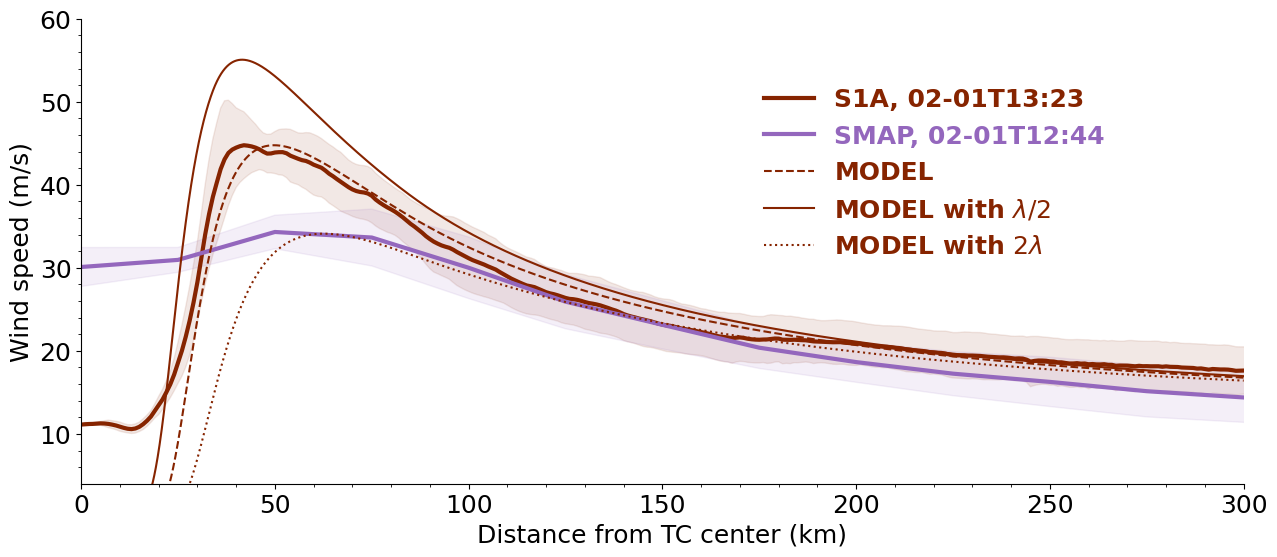

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))

# SAR 
ds = dsi.isel(time=1)
spdm_sar = ds.wind_speed.mean(dim='theta', skipna=True)
spds_sar = ds.wind_speed.std(dim='theta', skipna=True)
ax.plot(spdm_sar.rad / 1000, spdm_sar, c=cm(0.5), linewidth=3, label=r'{}, {}'.format(sensors[1], np.datetime_as_string(ds.time, unit='m')[5:]))
ax.fill_between(spdm_sar.rad / 1000, spdm_sar - spds_sar, spdm_sar + spds_sar, color=cm(0.5), alpha=0.1)

# RAD
spdm_rad = rad.wind_speed.mean(dim='theta', skipna=True)
spds_rad = rad.wind_speed.std(dim='theta', skipna=True)
ax.plot(rad.rad, spdm_rad, c='tab:purple', linewidth=3, label=r'SMAP, {}'.format(np.datetime_as_string(rad.acquisition_time, unit='m')[5:]))
ax.fill_between(rad.rad, spdm_rad - spds_rad, spdm_rad + spds_rad, color='tab:purple', alpha=0.1)

# MODEL
ax.plot(rs / 1000, Vm, c=cm(0.5), linestyle='dashed', label='MODEL')
ax.plot(rs / 1000, propagate(rs, float(case.a) * 2,   alpha, Vh, float(case.fcor_ini), dt=dt), c=cm(0.5), label=r'MODEL with $\lambda/2$')
ax.plot(rs / 1000, propagate(rs, float(case.a) * 0.5, alpha, Vh, float(case.fcor_ini), dt=dt), c=cm(0.5), linestyle='dotted', label=r'MODEL with $2\lambda$')

# Grids
ax.set_xlim(0, 300);ax.set_ylim(4, 60)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Wind speed (m/s)')
ax.spines[['right', 'top']].set_visible(False)
ax.minorticks_on()
ax.set_box_aspect(0.4)
ax.legend(labelcolor='linecolor', frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.9), prop=dict(weight='bold'))

# plt.savefig(PTHS['sav_dir'] + 'low_resolution.pdf', bbox_inches='tight', format='pdf')

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'low_resolution.pdf', bbox_inches='tight', format='pdf')

(array([5., 4., 4., 2., 3., 0., 2., 0., 1., 1.]),
 array([ 6364.10490699, 13353.27602293, 20342.44713886, 27331.6182548 ,
        34320.78937073, 41309.96048667, 48299.1316026 , 55288.30271854,
        62277.47383447, 69266.64495041, 76255.81606634]),
 <BarContainer object of 10 artists>)

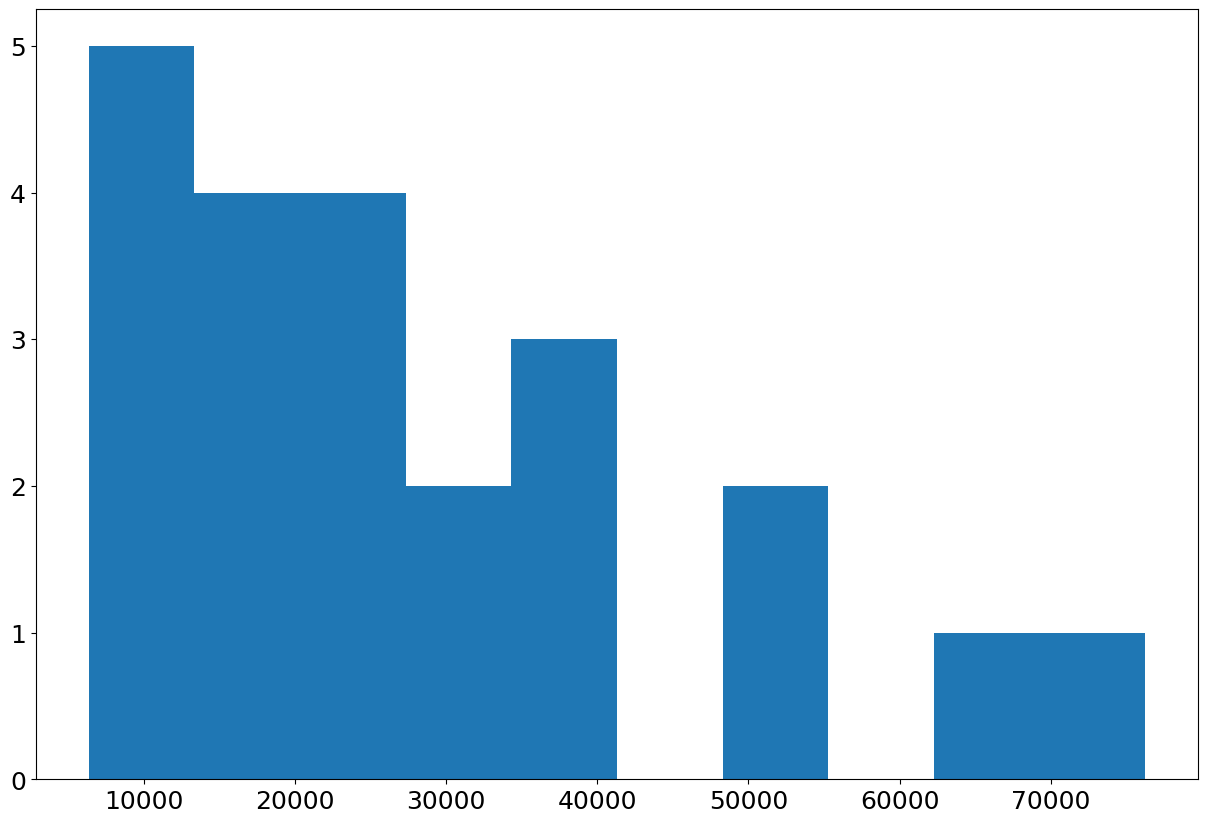

In [23]:
plt.hist(dsf.Hp)

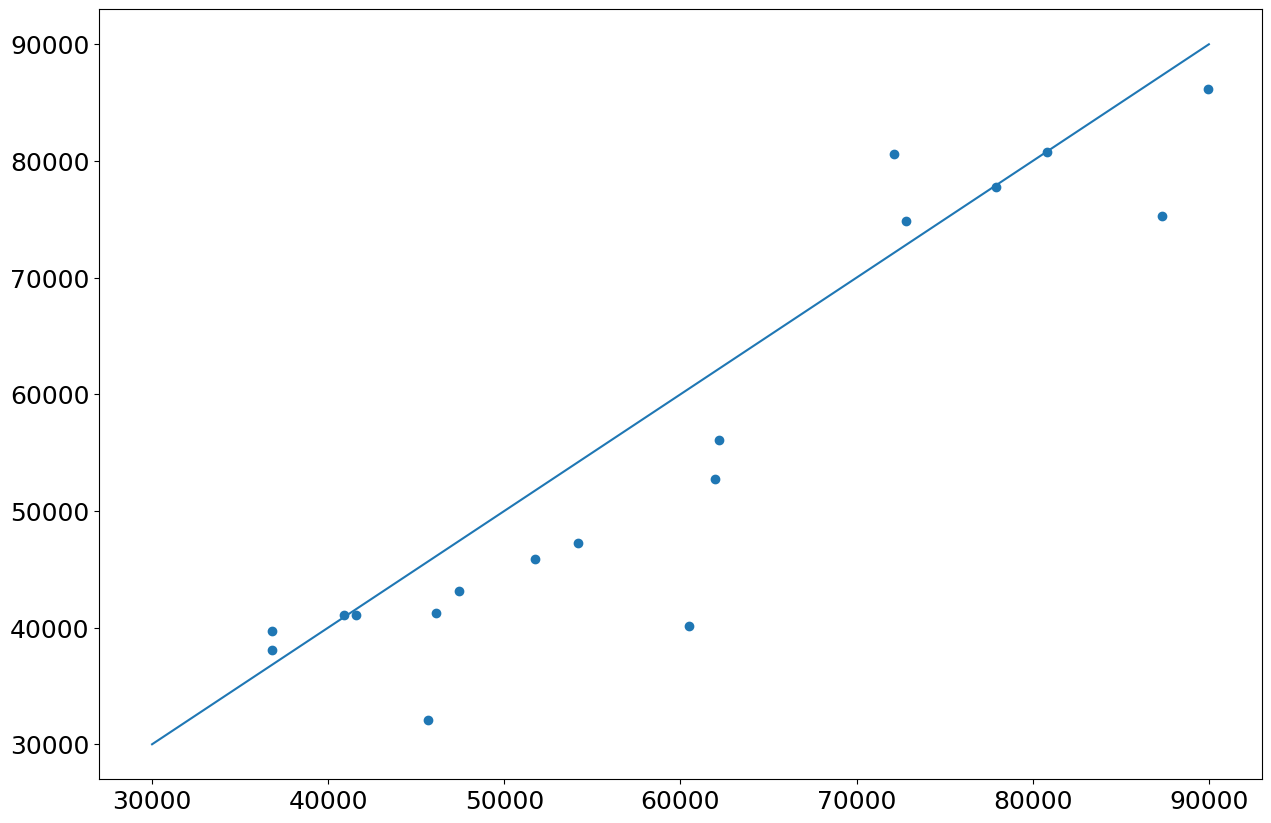

In [49]:
plt.scatter(d.Rp_fin, d.Rp_mod)
plt.plot([30000, 90000], [30000, 90000])

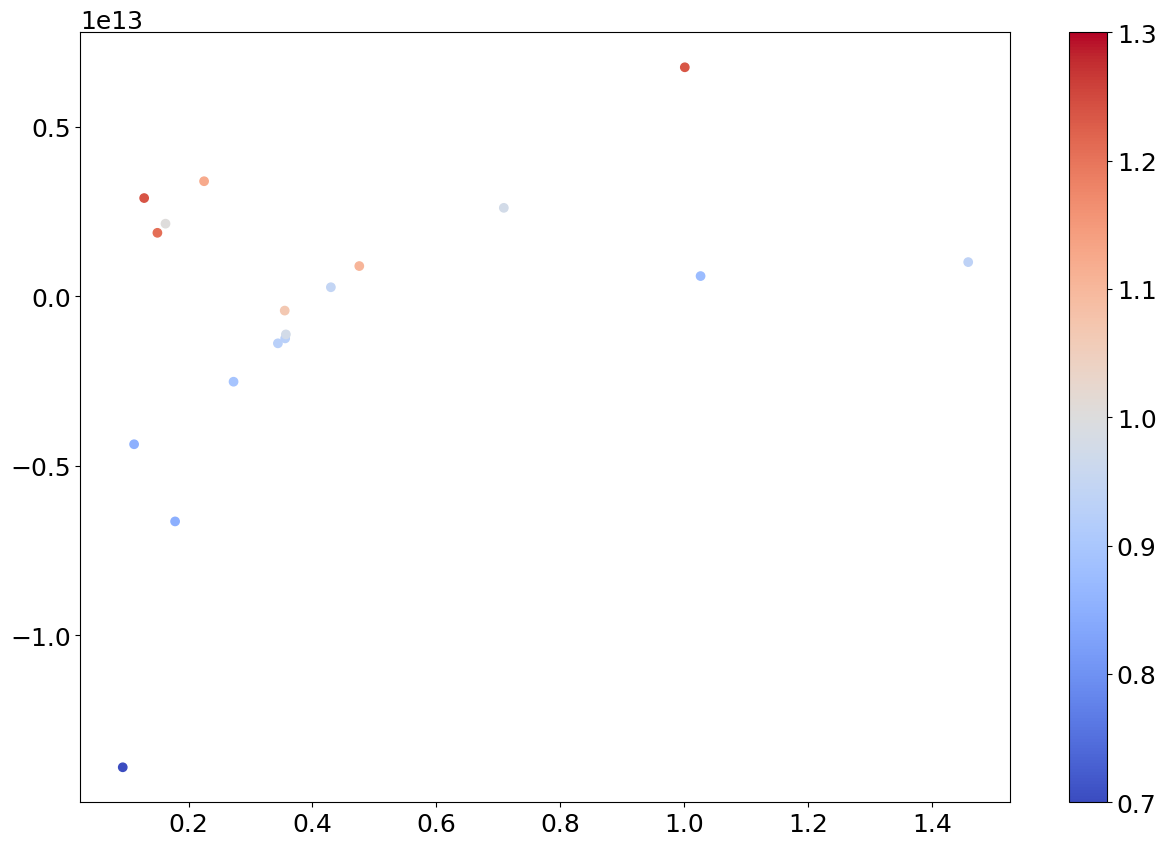

In [23]:
plt.scatter(y, d.dK_dt, c=d.R0_fin / d.R0_ini, cmap=mpl.cm.get_cmap('coolwarm'), vmin=0.7, vmax=1.3);plt.colorbar()

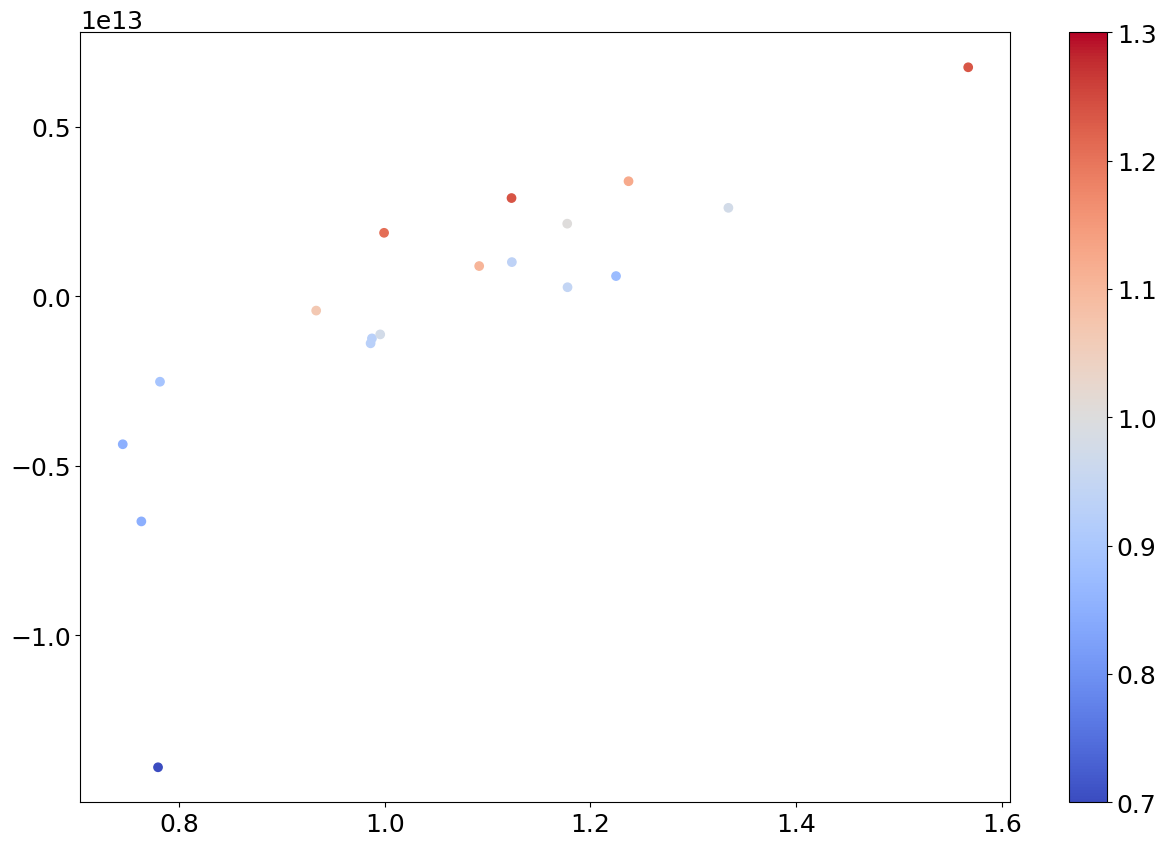

In [24]:
plt.scatter(d.vmx_fin / d.vmx_ini, d.dK_dt, c=d.R0_fin / d.R0_ini, cmap=mpl.cm.get_cmap('coolwarm'), vmin=0.7, vmax=1.3);plt.colorbar()

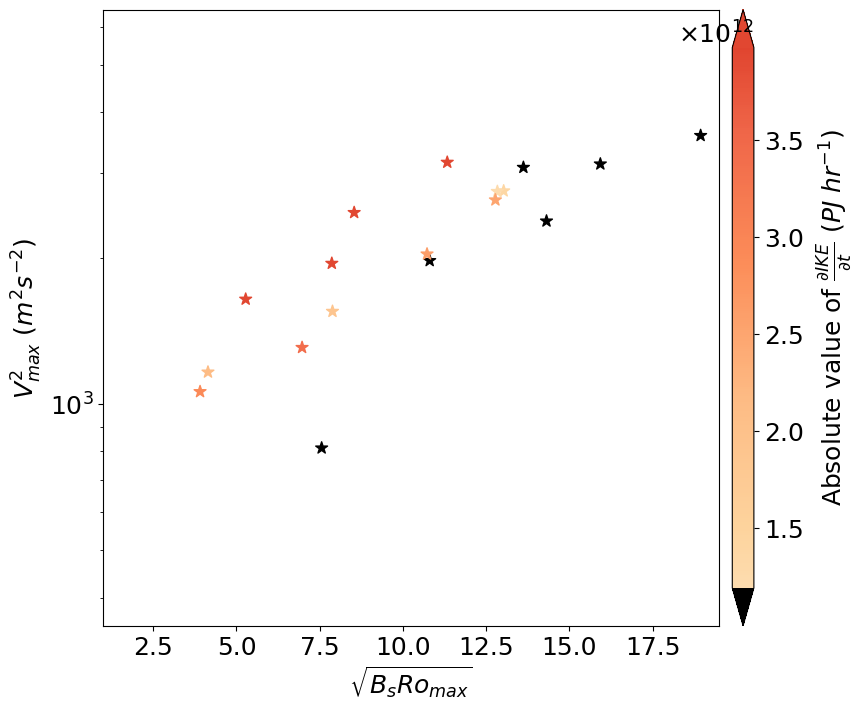

In [25]:
### COLORMAP
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap_ini = mpl.cm.get_cmap('OrRd')
cmap2    = truncate_colormap(cmap_ini, 0.2, 0.7) # Truncate colormap

c_min = abs(d.dK_dt).quantile(0.33)
c_max = abs(d.dK_dt).quantile(0.8)
cmap2.set_under('k')
cmap2.set_over(cmap2(0.99))

fig, ax = plt.subplots(figsize=(12, 8))

sm2 = ax.scatter(np.sqrt(d.B_hol * d.vmx_ini / (d.fcor_ini * d.rmx_ini)), d.vmx_ini ** 2, marker='*', s=80, c=abs(d.dK_dt), cmap=cmap2, vmin=c_min, vmax=c_max)

ax.set_box_aspect(1)
ax.set_yscale('log')
ax.set_ylim(3.5e2, 6.5e3)
ax.set_xlim(1, 19.5)
ax.set_ylabel(r'$V_{max}^2$ ($m^2 s^{-2}$)')
ax.set_xlabel(r'$\sqrt{B_s Ro_{max}}$')

cb_ax = fig.add_axes([0.78, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm2, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'Absolute value of $\frac{\partial IKE}{\partial t} $ ($PJ$ $hr^{-1}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

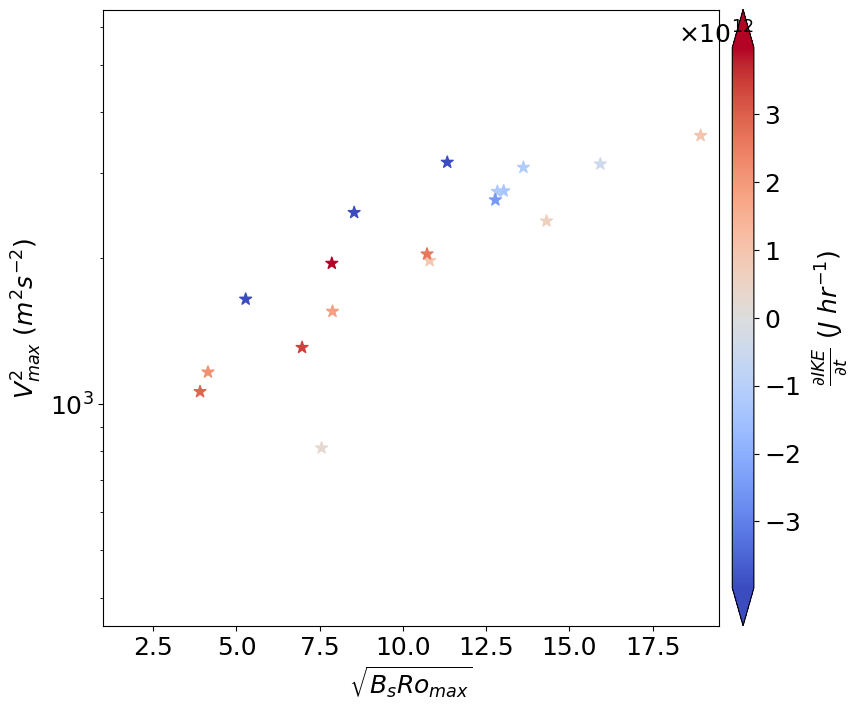

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

sm2 = ax.scatter(np.sqrt(d.B_hol * d.vmx_ini / (d.fcor_ini * d.rmx_ini)), d.vmx_ini ** 2, marker='*', s=80, c=d.dK_dt, vmin=-c_max, vmax=c_max, cmap=mpl.cm.get_cmap('coolwarm'))

# # Goni
# d1 = d.isel(pair=18)
# ax.scatter(np.sqrt(d1.B_hol * d1.vmx_ini / (d1.fcor_ini * d1.rmx_ini)), d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='k')
# d1 = d.isel(pair=19)
# ax.scatter(np.sqrt(d1.B_hol * d1.vmx_ini / (d1.fcor_ini * d1.rmx_ini)), d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='k')

# # Hector
# d1 = d.isel(pair=3)
# ax.scatter(np.sqrt(d1.B_hol * d1.vmx_ini / (d1.fcor_ini * d1.rmx_ini)), d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='r')
# d1 = d.isel(pair=4)
# ax.scatter(np.sqrt(d1.B_hol * d1.vmx_ini / (d1.fcor_ini * d1.rmx_ini)), d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='r')

# # Marie
# d1 = d.isel(pair=8)
# ax.scatter(np.sqrt(d1.B_hol * d1.vmx_ini / (d1.fcor_ini * d1.rmx_ini)), d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='g')
# d1 = d.isel(pair=9)
# ax.scatter(np.sqrt(d1.B_hol * d1.vmx_ini / (d1.fcor_ini * d1.rmx_ini)), d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='g')

ax.set_box_aspect(1)
ax.set_yscale('log')
ax.set_ylim(3.5e2, 6.5e3)
ax.set_xlim(1, 19.5)
ax.set_ylabel(r'$V_{max}^2$ ($m^2 s^{-2}$)')
ax.set_xlabel(r'$\sqrt{B_s Ro_{max}}$')

cb_ax = fig.add_axes([0.78, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm2, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'$\frac{\partial IKE}{\partial t} $ ($J$ $hr^{-1}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

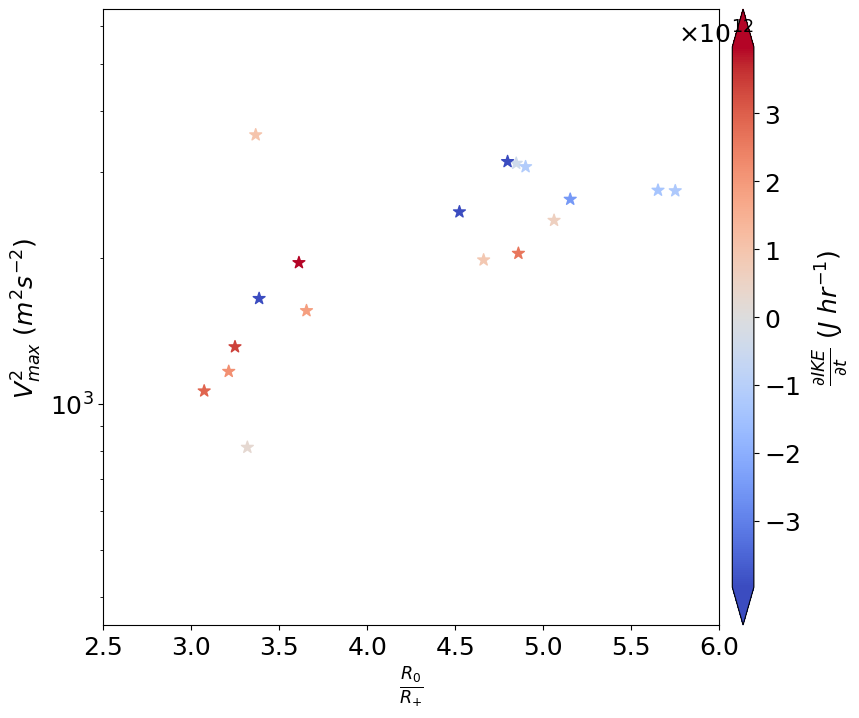

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

sm2 = ax.scatter(d.R0_ini / d.Rp_ini, d.vmx_ini ** 2, marker='*', s=80, c=d.dK_dt, vmin=-c_max, vmax=c_max, cmap=mpl.cm.get_cmap('coolwarm'))

# # Goni
# d1 = d.isel(pair=18)
# ax.scatter(d1.R0_ini / d1.Rp_ini, d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='k')
# d1 = d.isel(pair=19)
# ax.scatter(d1.R0_ini / d1.Rp_ini, d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='k')

# # Hector
# d1 = d.isel(pair=3)
# ax.scatter(d1.R0_ini / d1.Rp_ini, d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='r')
# d1 = d.isel(pair=4)
# ax.scatter(d1.R0_ini / d1.Rp_ini, d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='r')

# # Marie
# d1 = d.isel(pair=8)
# ax.scatter(d1.R0_ini / d1.Rp_ini, d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='g')
# d1 = d.isel(pair=9)
# ax.scatter(d1.R0_ini / d1.Rp_ini, d1.vmx_ini ** 2, marker='o', s=100, facecolors='none', edgecolors='g')

ax.set_box_aspect(1)
ax.set_yscale('log')
ax.set_ylim(3.5e2, 6.5e3)
ax.set_xlim(2.5, 6)
ax.set_ylabel(r'$V_{max}^2$ ($m^2 s^{-2}$)')
ax.set_xlabel(r'$\frac{R_0}{R_{+}}$')

cb_ax = fig.add_axes([0.78, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm2, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'$\frac{\partial IKE}{\partial t} $ ($J$ $hr^{-1}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

In [ ]:
plt.scatter(d.Rp_fin, d.Rp_mod)
plt.scatter(d.Rp_fin, d.Rp_ini, c='r')
plt.plot([30000, 90000], [30000, 90000])

### 4) BL Heights

(array([3., 2., 0., 0., 0., 3., 0., 1., 1., 1., 1., 0., 2., 0., 1., 0., 0.,
        0., 3., 2.]),
 array([ 778.82763488,  846.66632895,  914.50502302,  982.34371709,
        1050.18241116, 1118.02110523, 1185.85979929, 1253.69849336,
        1321.53718743, 1389.3758815 , 1457.21457557, 1525.05326964,
        1592.89196371, 1660.73065778, 1728.56935185, 1796.40804592,
        1864.24673998, 1932.08543405, 1999.92412812, 2067.76282219,
        2135.60151626]),
 <BarContainer object of 20 artists>)

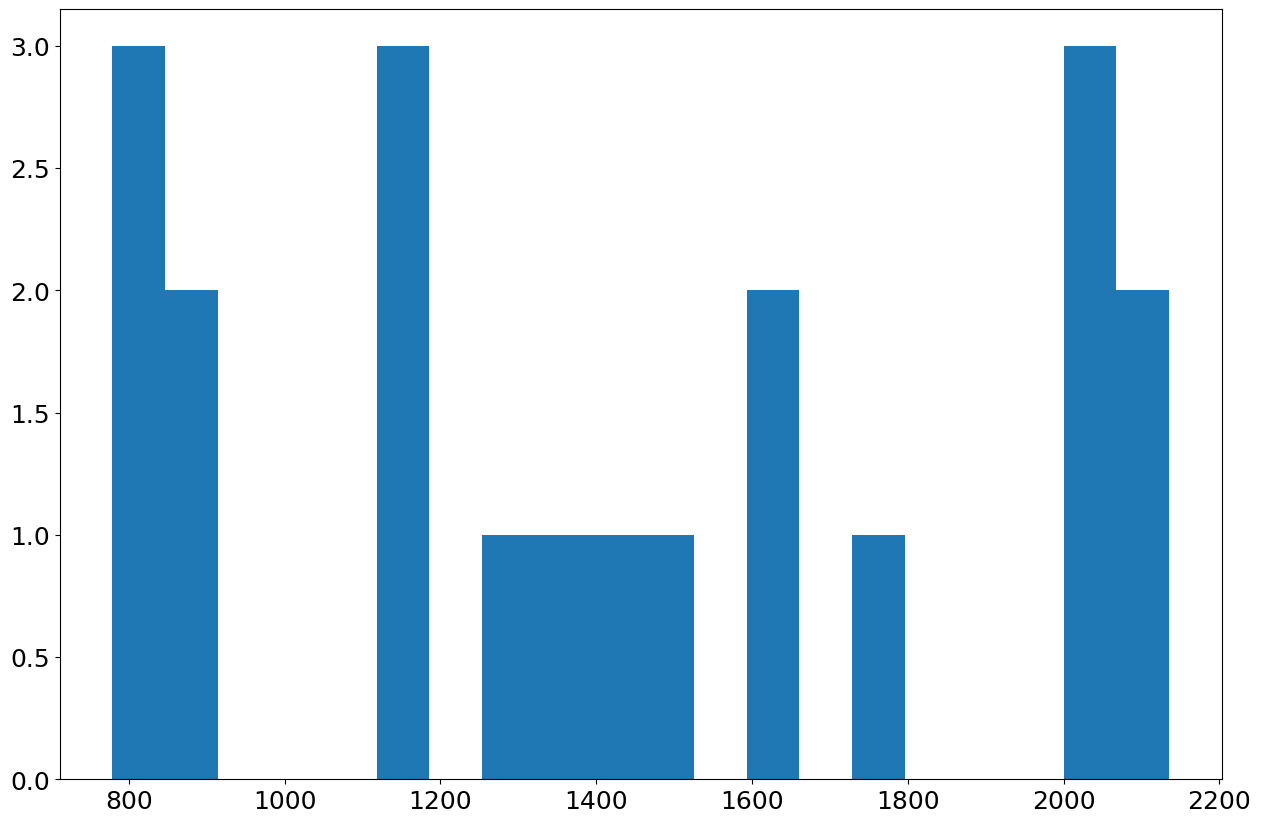

In [345]:
# Figure
fig, ax = plt.subplots(figsize=(15, 10))

ax.hist(d.hp, bins=20)

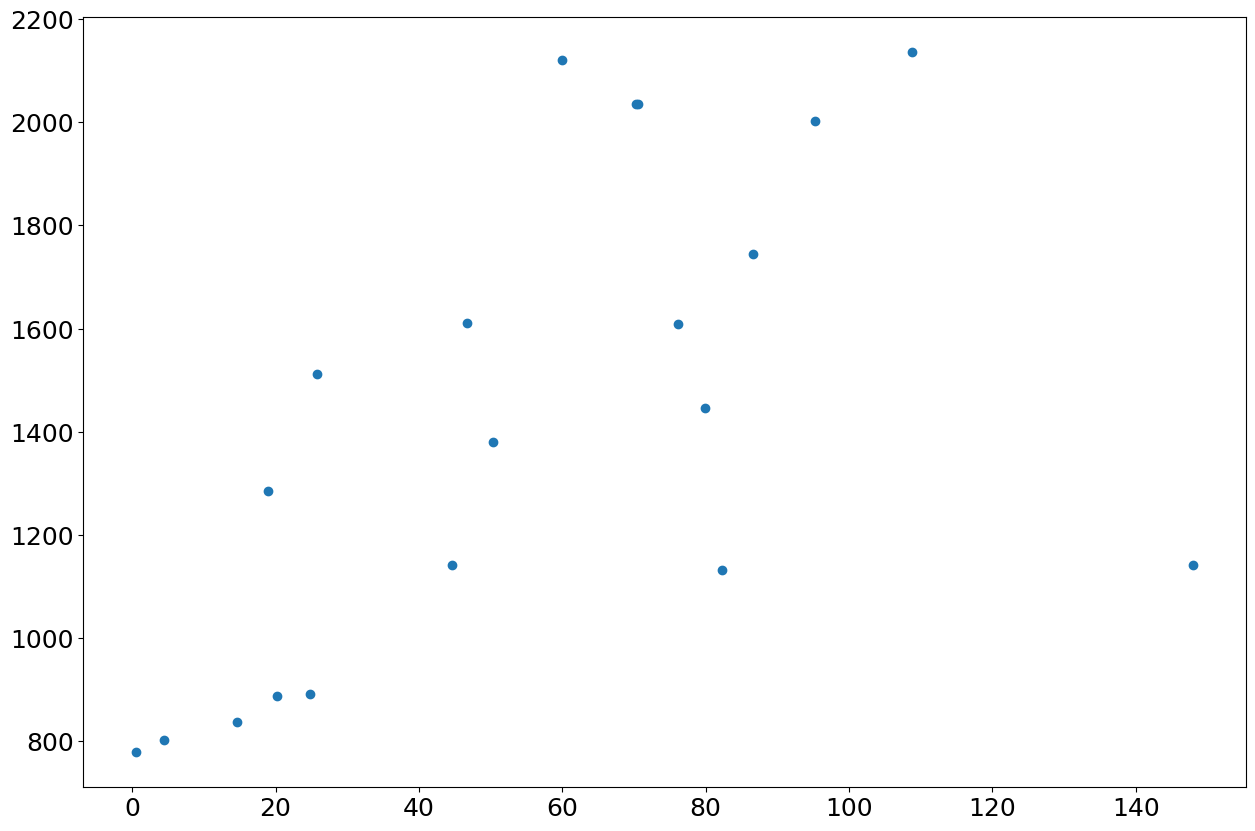

In [61]:
plt.scatter((d.vmx_ini ** 2 - d.Vp_ini ** 2) / 20, d.hp)
# plt.plot([40, 160], [40, 160])

In [63]:
# plt.scatter(X1, y, c=d.R0_fin / d.R0_ini, cmap=cmap, vmin=0.9, vmax=1.1);plt.colorbar(label='R0 final / R0 initial')
# plt.xlabel('R+ / Rm');plt.ylabel('gamma')

In [64]:
# plt.scatter(X1, y, c=d.R0_ini / d.rmx_ini, cmap=cmap, vmin=6, vmax=12);plt.colorbar(label='R0 / Rmax')
# plt.xlabel('R+ / Rm');plt.ylabel('gamma')

Text(0.5, 0, 'R0 / R+')

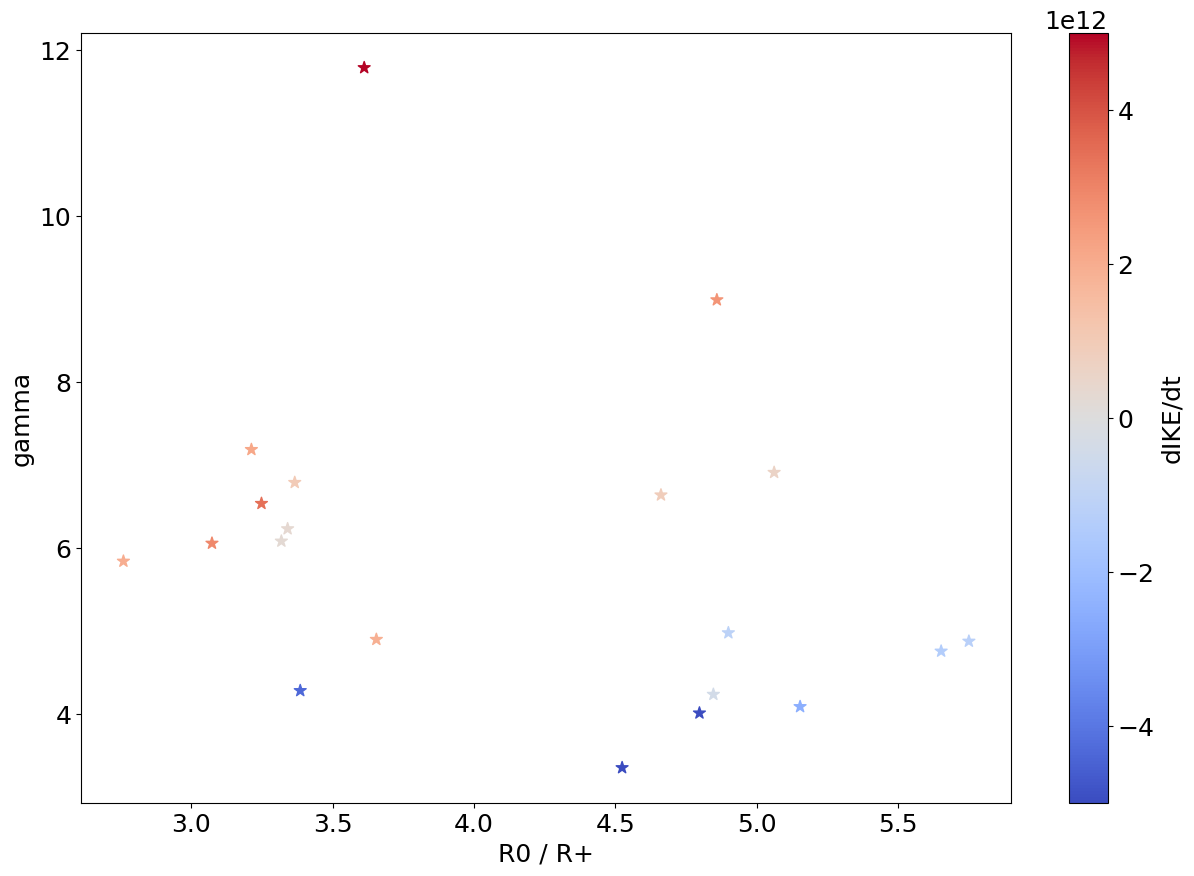

In [346]:
plt.scatter(d.R0_ini / d.Rp_ini, y, c=d.dK_dt, cmap=cmap, vmin=-0.5e13, vmax=0.5e13, marker='*', s=80);plt.colorbar(label='dIKE/dt')
plt.ylabel('gamma');plt.xlabel('R0 / R+')

Text(0.5, 0, 'R0 / R+')

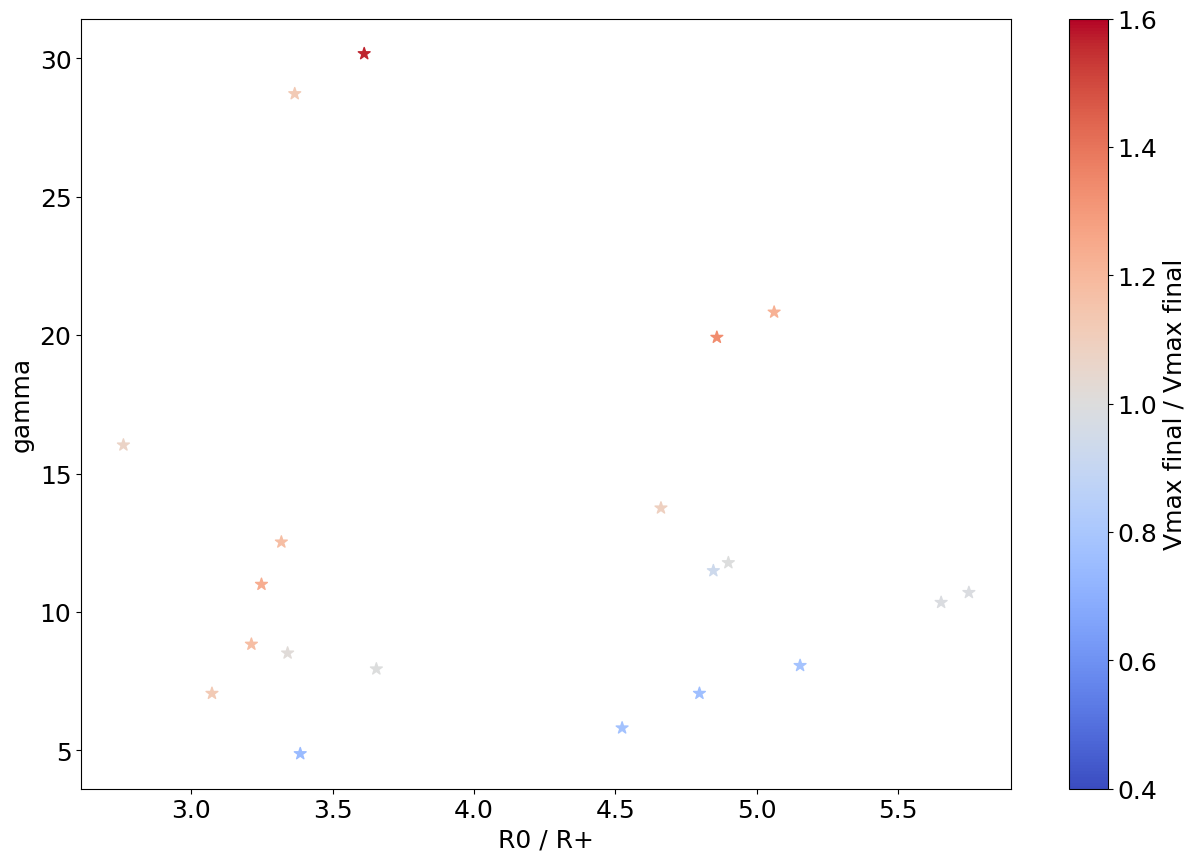

In [66]:
plt.scatter(d.R0_ini / d.Rp_ini, y, c=X2, cmap=cmap, vmin=c_min, vmax=c_max, marker='*', s=80);plt.colorbar(label='Vmax final / Vmax final')
plt.ylabel('gamma');plt.xlabel('R0 / R+')

### Test with SST

In [67]:
### ADD SST (1)
dsg2 = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg2 = dsg2.where(dsg2.distance_to_coast > dsg2.R17_1D * 1000, drop=True)
dsg2 = dsg2.where(abs(dsg2.lat_center) < 30, drop=True)
dsg2 = dsg2.where(dsg2.B_hol > 0.1, drop=True)
dsg2 = dsg2.where(dsg2.Vmax_1D > 20, drop=True)
print('Nb of storms: {}'.format(len(dsg2.time)))

sst_pth = '/home/arthur/data/sst/dsg_sst_combot.nc'
sst     = xr.open_dataset(sst_pth)

dsg2['prestorm_sst'] = xr.DataArray(
    data=np.array(sst.prestorm_SST),
    dims={'time': dsg2.time}
)
dsg2['rSST'] = xr.DataArray(
    data=np.array(sst.rSST),
    dims={'time': dsg2.time}
)

# Additional filter
dsg2 = dsg2.where(dsg2.Vmax_1D > 30, drop=True)

### ADD SST (2)
dsf['pre_sst'] = dsf.a.copy(deep=True) * np.nan
dsf['rel_sst'] = dsf.a.copy(deep=True) * np.nan
for p in tqdm(range(len(dsf.pair))):
    dsf.pre_sst[p] = dsg2.where(dsg2.storm_id == dsf.isel(pair=p).tc_id, drop=True).isel(time=dsf.isel(pair=p).idx_ini).prestorm_sst
    dsf.rel_sst[p] = dsg2.where(dsg2.storm_id == dsf.isel(pair=p).tc_id, drop=True).isel(time=dsf.isel(pair=p).idx_ini).rSST

Nb of storms: 184


  0%|          | 0/22 [00:00<?, ?it/s]

Text(0, 0.5, 'gamma')

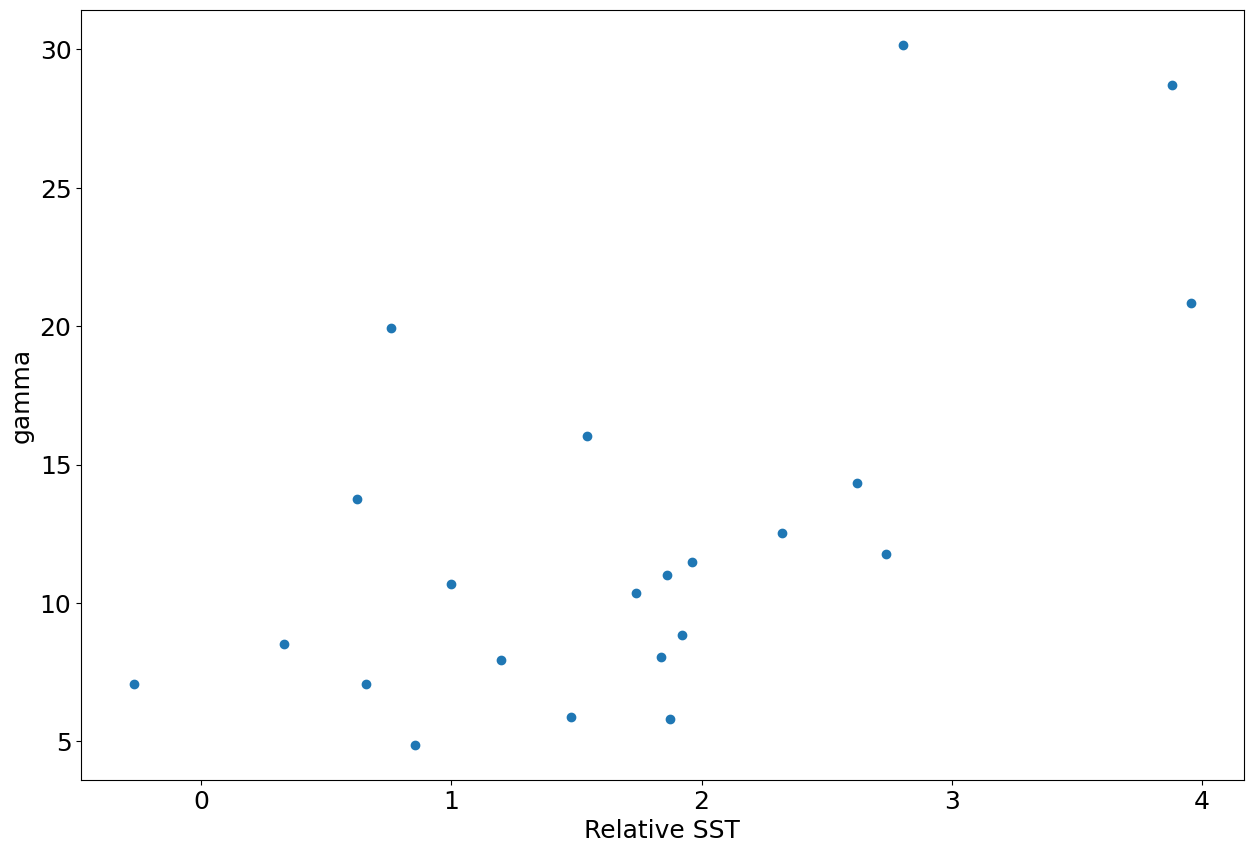

In [68]:
plt.scatter(dsf.rel_sst, dsf.Hp / dsf.hp)
plt.xlabel('Relative SST');plt.ylabel('gamma')

Text(0.5, 0, 'R0 / R+')

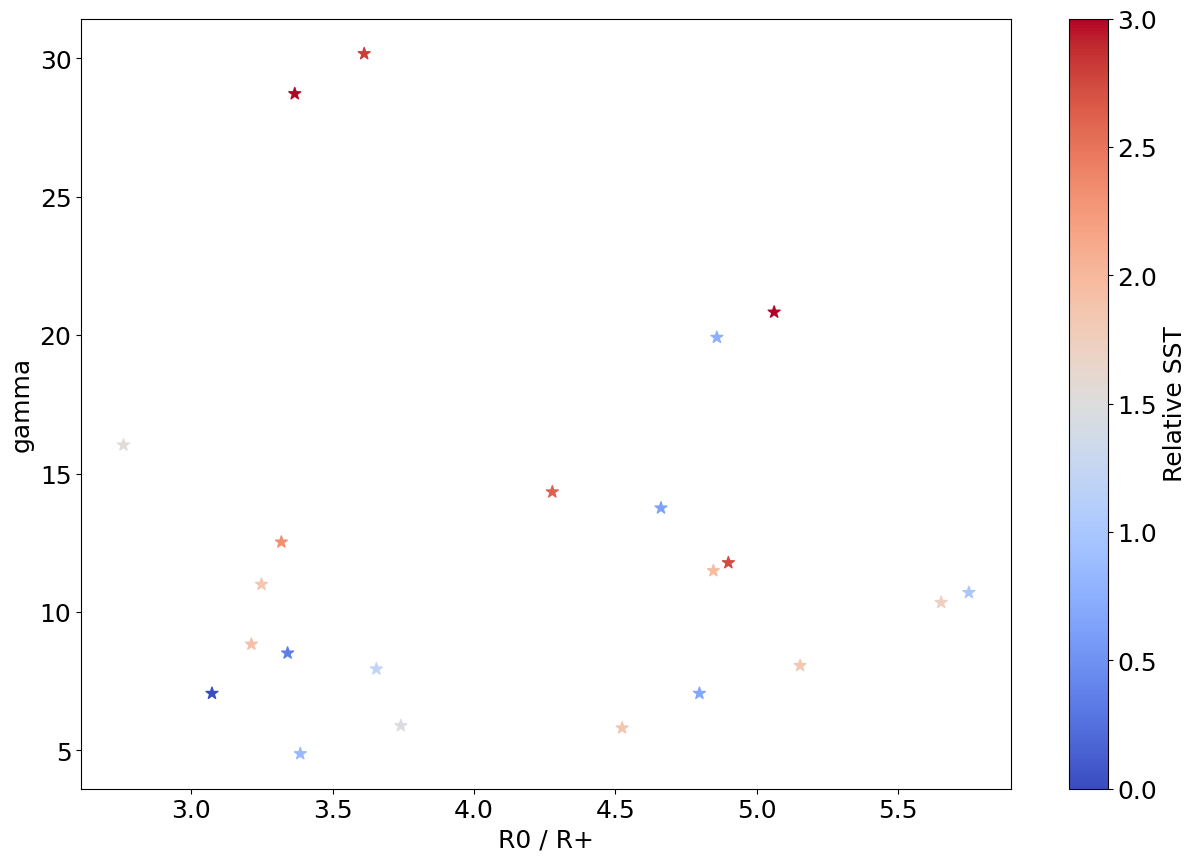

In [69]:
plt.scatter(dsf.R0_ini / dsf.Rp_ini, dsf.Hp / dsf.hp, c=dsf.rel_sst, cmap=cmap, vmin=0, vmax=3, marker='*', s=80);plt.colorbar(label='Relative SST')
plt.ylabel('gamma');plt.xlabel('R0 / R+')

Text(0.5, 0, 'R0 / R+')

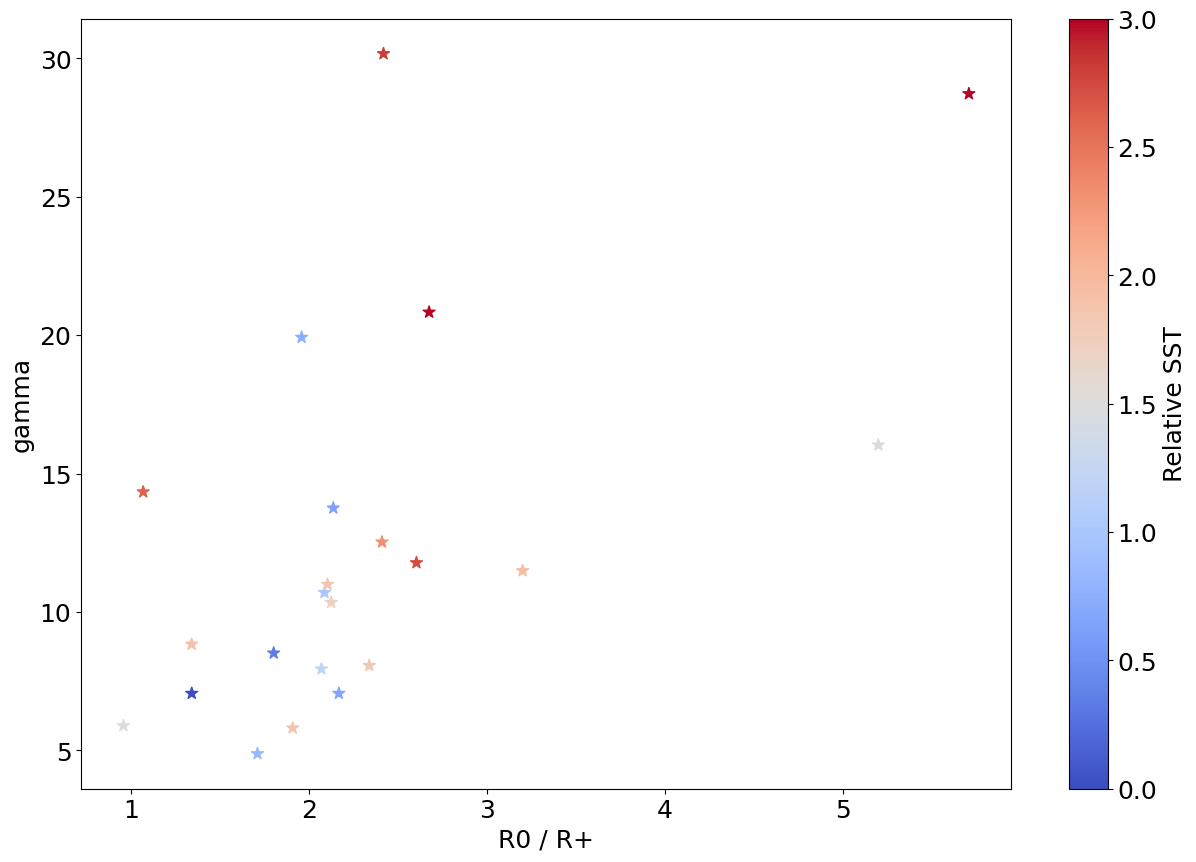

In [70]:
plt.scatter(dsf.Rp_ini / dsf.rmx_ini, dsf.Hp / dsf.hp, c=dsf.rel_sst, cmap=cmap, vmin=0, vmax=3, marker='*', s=80);plt.colorbar(label='Relative SST')
plt.ylabel('gamma');plt.xlabel('R0 / R+')

In [446]:
# fig, ax = plt.subplots(figsize=(15, 10))

# sm = ax.scatter(d.vmx_fin / d.vmx_ini, d.Hp / d.hp, c=d.Rp_ini / d.rmx_ini, cmap=mpl.cm.get_cmap('coolwarm'), vmin=1, vmax=3, marker='*', s=80)

# # Grids
# ax.set_ylabel(r'$\gamma$')
# ax.set_xlabel(r'$\frac{V_{max, final}}{V_{max, initial}}$')
# ax.minorticks_on()
# ax.tick_params(length=7, width=1.2)
# ax.spines[['right', 'top']].set_visible(False)

# # Colorbar
# # cb_ax = fig.add_axes([0.92, 0.11, 0.028, 0.77])
# cb_ax = fig.add_axes([0.78, 0.11, 0.018, 0.77])
# cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
# cbar.formatter.set_useMathText(True)
# # cbar.formatter.set_powerlimits((0, 0))
# cbar.set_label(r'$\frac{R_{+}}{R_{max}}$', rotation=90)
# cbar.ax.get_yaxis().labelpad=8

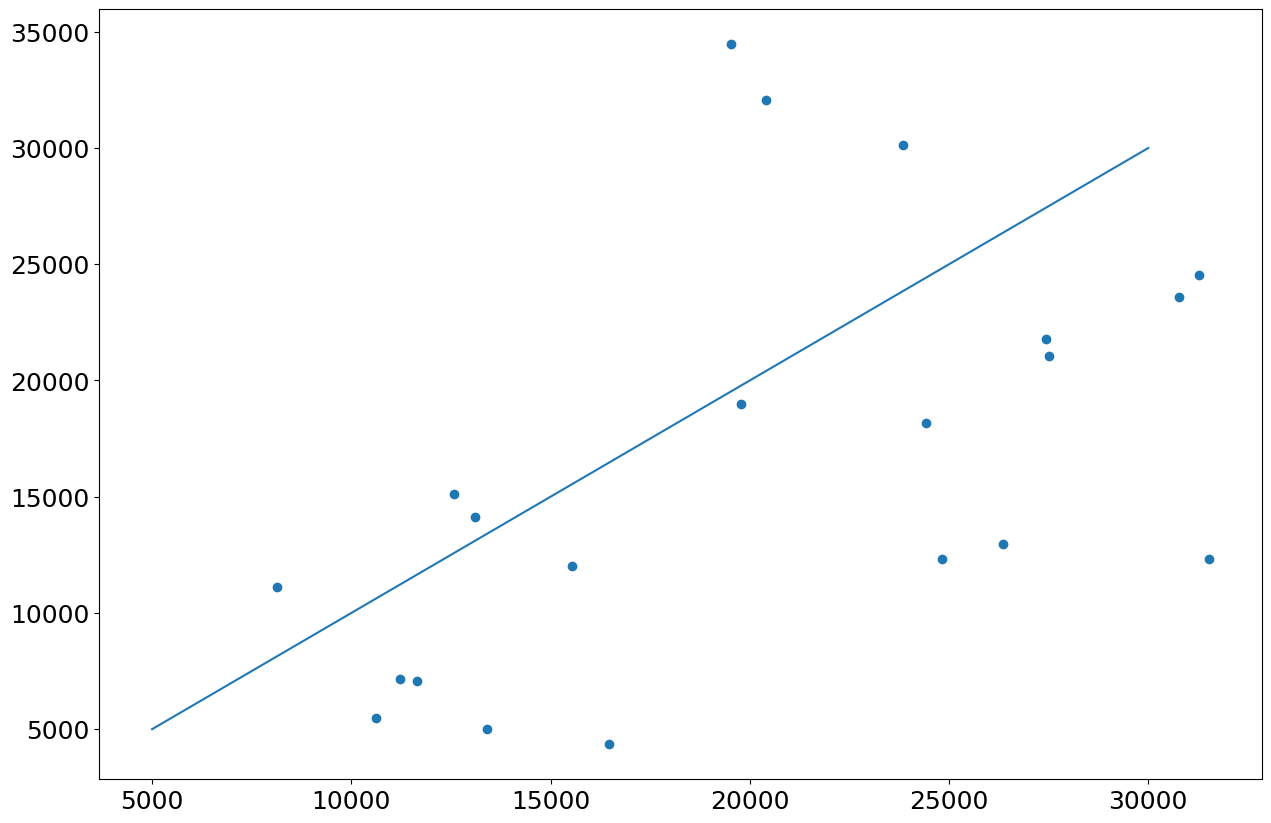

In [443]:
plt.scatter(dsf.vmx_ini ** 2 / 1e-1, dsf.Hp)
plt.plot([5000, 30000], [5000, 30000])

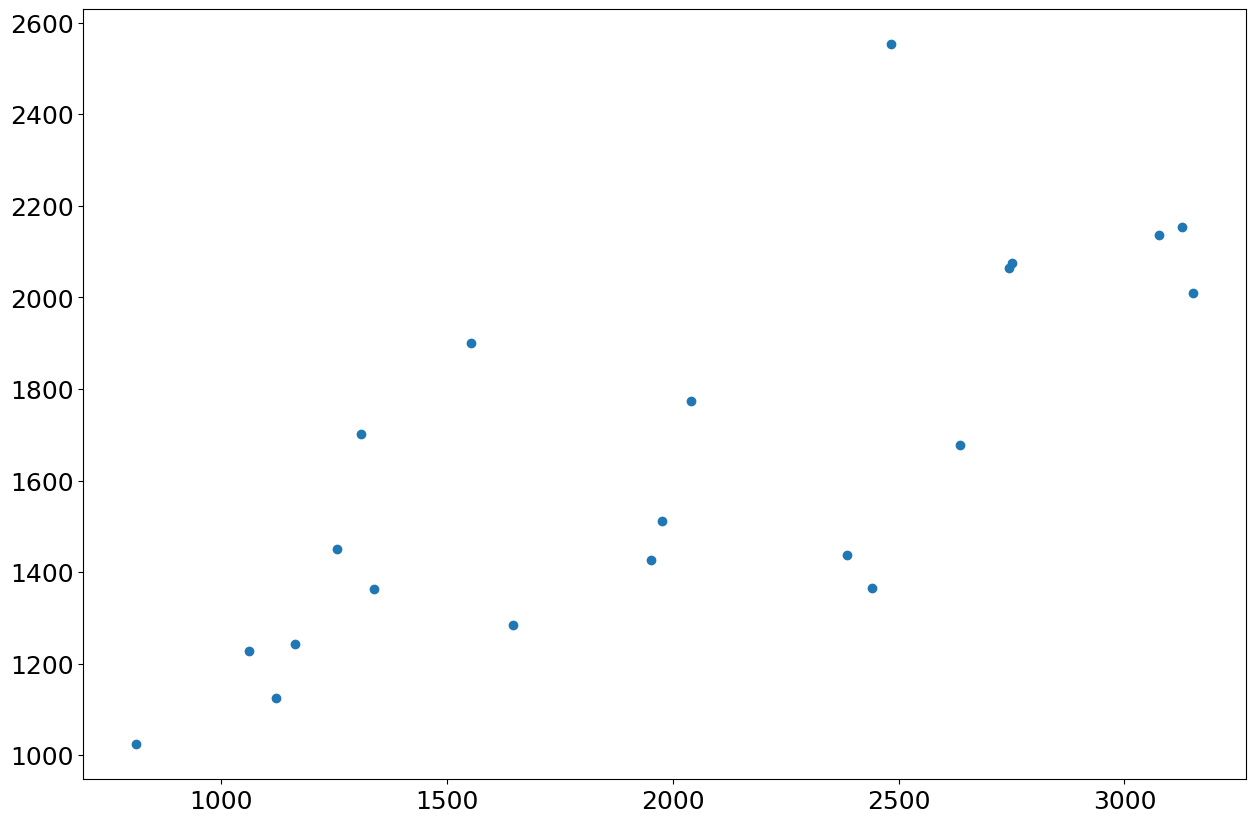

In [444]:
plt.scatter(dsf.vmx_ini ** 2, dsf.hp)

### 4) INFERENCES

In [ ]:
# Iterate
for p, tc_id in tqdm(enumerate(d.tc_id)):
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    # dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    dsi        = dsg.where(dsg.storm_id == tc_id.item(), drop=True).sortby('time')
    dp         = d.isel(pair = p)
    ds_ini     = dsi.isel(time=int(dp.idx_ini))
    ds_fin     = dsi.isel(time=int(dp.idx_fin))   
    V_ini      = ds_ini.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
    V_fin      = ds_fin.wind_speed.mean(dim='theta', skipna=True).interp(coords={'rad': rs})
    Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
    Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
    
    tau        = ((1 / dp.fcor_ini) / 3600)
    dt         = float(dp.delta_h / tau)
    
    x1         = dp.Rp_ini / dp.rmx_ini
    x2         = dp.vmx_fin / dp.vmx_ini
    gamma      = reg.coef_[0] * x1 + reg.coef_[1] * x2 + reg.intercept_
    a          = (gamma * dp.hp) / dp.Rp_ini

    # Plot
    if PRMS['sav_inf']:
        plt.title('{}, idx_ini = {}, idx_fin = {} \n delta_h = {:.1f} hrs, a = {:.2f}'.format(tc_id.item(), int(idx_ini), int(idx_fin), dp.delta_h.item(), float(a)), weight='bold')
        # SAR                  
        plt.plot(rs / 1000, V_ini, c='k',         linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(ds_ini.time, unit='m')[5:]))
        plt.plot(rs / 1000, V_fin, c='orangered', linewidth=3, label=r'SAR, {}'.format(np.datetime_as_string(ds_fin.time, unit='m')[5:]))
        # Holland
        plt.plot(rs / 1000, Vh_ini, linewidth=3, linestyle='dotted', c='k', label='Holland initial')
        plt.plot(rs / 1000, Vh_fin, linewidth=3, linestyle='dotted', c='orangered', label='Holland final')
        # Model
        for k in range(1, l + 1):
            V = propagate(rs, float(a), Vh_ini, float(dp.fcor_ini), dt=k * dt / l)
            plt.plot(rs / 1000, V, linestyle='dashed', c=clrs[k], label='MODEL, step {}'.format(k))
        # Grids
        plt.grid();plt.legend(loc='upper right')
        plt.xlim(0, 300)
        plt.xlabel('r (km)')
        plt.ylabel('Wind speed (m/s)')

        # Save
        plt.savefig(PTHS['sav_dir'] + 'inferences/{}_ini{}_fin{}'.format(tc_id.item(), int(idx_ini), int(idx_fin)));plt.clf()